# **YOLO OBJECT DETECTION ASSESSMENT**

Tasks :
- The dataset given consists of images of `live` and `spoof` data.
- You may use any open-source YOLO repositories to complete this assessment.
- Please try to complete section by section.
- There are 2 types of assessment to be completed:
  - Code
  - Explanation  

<!-- - Please use images from `train` and `val` -->
<!-- - steps (sections) are given for this tasks (task G is optional) -->
<!-- - detect live or spoof with given dataset
- train and val file for training your model
- test file to verify your results
- you might use any open source yolo resources to done your assignment -->

Note:
- This assessment should be completed in a week. Please manage your time accordingly.
- Ensure that **ALL** code blocks has been executed, including training, evaluation, benchmark and visualizations upon submission.
<!-- - Add comment to your codes.  -->

<!-- note :
- this assessment should be hand done in a week
- any training, evaluation, benchmark and any visualisations results done is a must to run in jupyter notebook or colab notebook so the results can be straight away reviewed without re-run the code
- your training could be a run by cli, code or any library
- pls give explanations for all the results
- if no code is fill in you can comment your explainations
- any idea and thoughts can be commented and outline them
- fill up the explaination in markdown
- fill up the code in code
- you might add more markdown and code section -->

Reference :
- https://pyimagesearch.com/2022/06/20/training-the-yolov5-object-detector-on-a-custom-dataset/
- https://github.com/ultralytics/ultralytics


7 sections to be completed:

A) PREPROCESSING

B) VISUALIZE PREPROCESSED DATA

C) TRAINING

D) FINDINGS AND CONCLUSION

E) EVALUATE ON TEST SETS

F) SUMMARIZE AND IMPROVEMENTS

G) BONUS POINTS

## A) PREPROCESSING
- Dataset Distribution:
  - Train: 120
  - Validation: 20
  - Test: 20
<!-- you are given datasets : 120 for train , 20 for val , 20 for test -->
- Annotation text file is given in the following format:
  - class_index, x-center, y-center, w , h

Task(s):
- Resize image size
- Recalculate resized images' coordinates:
  - x-center_resized, y-center_resized, w_resized , h_resized
- All the results should be in thier respective folder(s):
    - images/train , images/val, image/test
    - labels/train , labels/val, labels/test
    - *HINT: different YOLO versions/ repositories may have different directory format*

In [1]:
!nvidia-smi

Thu Aug 29 10:58:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.76                 Driver Version: 560.76         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX250         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   59C    P8             N/A / ERR!  |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
import sys
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
from IPython.display import display, Image

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
  sys.path.append(project_root)

from utils import draw

In [2]:
dataset_raw_path = '../data/raw'
dataset_processed_path = '../data/processed'

In [3]:
with open(f'{dataset_raw_path}/train.txt', 'r') as file:
  train_dirs = [line.strip() for line in file]

with open(f'{dataset_raw_path}/val.txt', 'r') as file:
  val_dirs = [line.strip() for line in file]

with open(f'{dataset_raw_path}/test.txt', 'r') as file:
  test_dirs = [line.strip() for line in file]

In [4]:
base_dirs = [f'{dataset_processed_path}/images', f'{dataset_processed_path}/labels']
sub_dirs = ['train', 'val', 'test']

for base in base_dirs:
  for sub in sub_dirs:
    os.makedirs(os.path.join(base, sub), exist_ok=True)

In [7]:
for split, dirs in zip(['train', 'val', 'test'], [train_dirs, val_dirs, test_dirs]):
  for dir in tqdm(dirs, desc=f'Processing {split} split'):
    filename = os.path.splitext(os.path.basename(dir))[0]

    # Resize image
    img = cv2.imread(f'{dataset_raw_path}/images/{split}/{filename}.png')
    h_old, w_old = img.shape[:2]
    h_new, w_new = 640, 640
    resized_img = cv2.resize(img, (h_new, w_new))
    cv2.imwrite(f'{dataset_processed_path}/images/{split}/{filename}.png', resized_img)

    # Resize label
    scale_x = w_new / w_old
    scale_y = h_new / h_old

    with open(f'{dataset_raw_path}/labels/{split}/{filename}.txt', 'r') as file:
      line = file.readline().strip().split()
      label = int(line[0])
      x_center = float(line[1])
      y_center = float(line[2])
      w_bbox = int(line[3])
      h_bbox = int(line[4])

      x_center_resized = x_center * scale_x / w_new
      y_center_resized = y_center * scale_y / h_new
      w_resized = w_bbox * scale_x / w_new
      h_resized = h_bbox * scale_y / h_new

    with open(f'{dataset_processed_path}/labels/{split}/{filename}.txt', 'w') as file:
      file.write(f'{label} {x_center_resized} {y_center_resized} {w_resized} {h_resized}')

Processing test split: 100%|██████████| 20/20 [00:00<00:00, 24.16it/s]


## B) VISUALIZE PREPROCESSED DATA
- draw bounding box on any 10 images from task A to verify processed datasets and coordinates

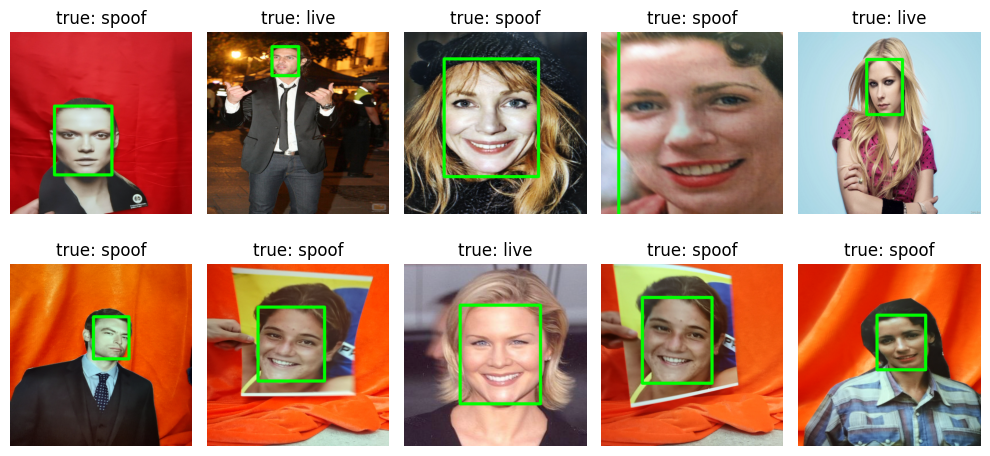

In [4]:
# Folder paths
image_folder = f'{dataset_processed_path}/images/train'
label_folder = f'{dataset_processed_path}/labels/train'

# Get the first 10 image files
image_files = sorted(os.listdir(image_folder))[:10]

# Create a 2 by 5 subplot
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, image_file in enumerate(image_files):
  # Read the image
  img_path = os.path.join(image_folder, image_file)
  img = cv2.imread(img_path)
  h, w = img.shape[:2]
  
  # Read the corresponding label
  label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + '.txt')
  with open(label_path, 'r') as file:
    line = file.readline().strip().split()
    label = 'spoof' if int(line[0]) else 'live'
    x_center = float(line[1]) * w
    y_center = float(line[2]) * h
    w_bbox = float(line[3]) * w
    h_bbox = float(line[4]) * h
  
  # Draw the bounding box on the image
  draw.draw_bbox(img, x_center, y_center, w_bbox, h_bbox, (0, 255, 0))
  
  # Convert the image from BGR to RGB
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # Plot the image in the subplot
  ax = axes[i // 5, i % 5]
  ax.imshow(img_rgb)
  ax.axis('off')
  ax.set_title(f'true: {label}')

plt.tight_layout()
plt.show()

## C) TRAINING

- Please include your training parameters. (screenshot/ in written form)
<!-- pls include your configuration written here all screenshot of your parameters setup and etc -->
- Specify your output directory path.
  - Model
  - Plots
  - Images (if you have any)

*Hints : according to yolo, you need to have the following files:*
  - hyp yaml file
  - dataset yaml file
  - model yaml file

In [29]:
# Load model
model = YOLO("yolov8n.yaml")  # build a new model from YAML
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolov8n.yaml").load("yolov8n.pt")  # build from YAML and transfer weights

100%|██████████| 6.25M/6.25M [00:20<00:00, 322kB/s]


Transferred 355/355 items from pretrained weights


In [ ]:
# Train the model
results = model.train(data='../config/dataset.yaml', epochs=30, imgsz=640, device=[0], project_root='../runs')

## D) FINDINGS
- Please state your findings on:
  - Benchmark
  - Performance
  - Visualization

### 1. Confusion Matrix

The confusion matrix is a table used to evaluate the performance of a classification model. It shows the actual versus predicted classifications made by the model.

Based on the confusion matrix: 
- 10 *live* samples predicted as *live*
- 9 *spoof* samples predicted as 

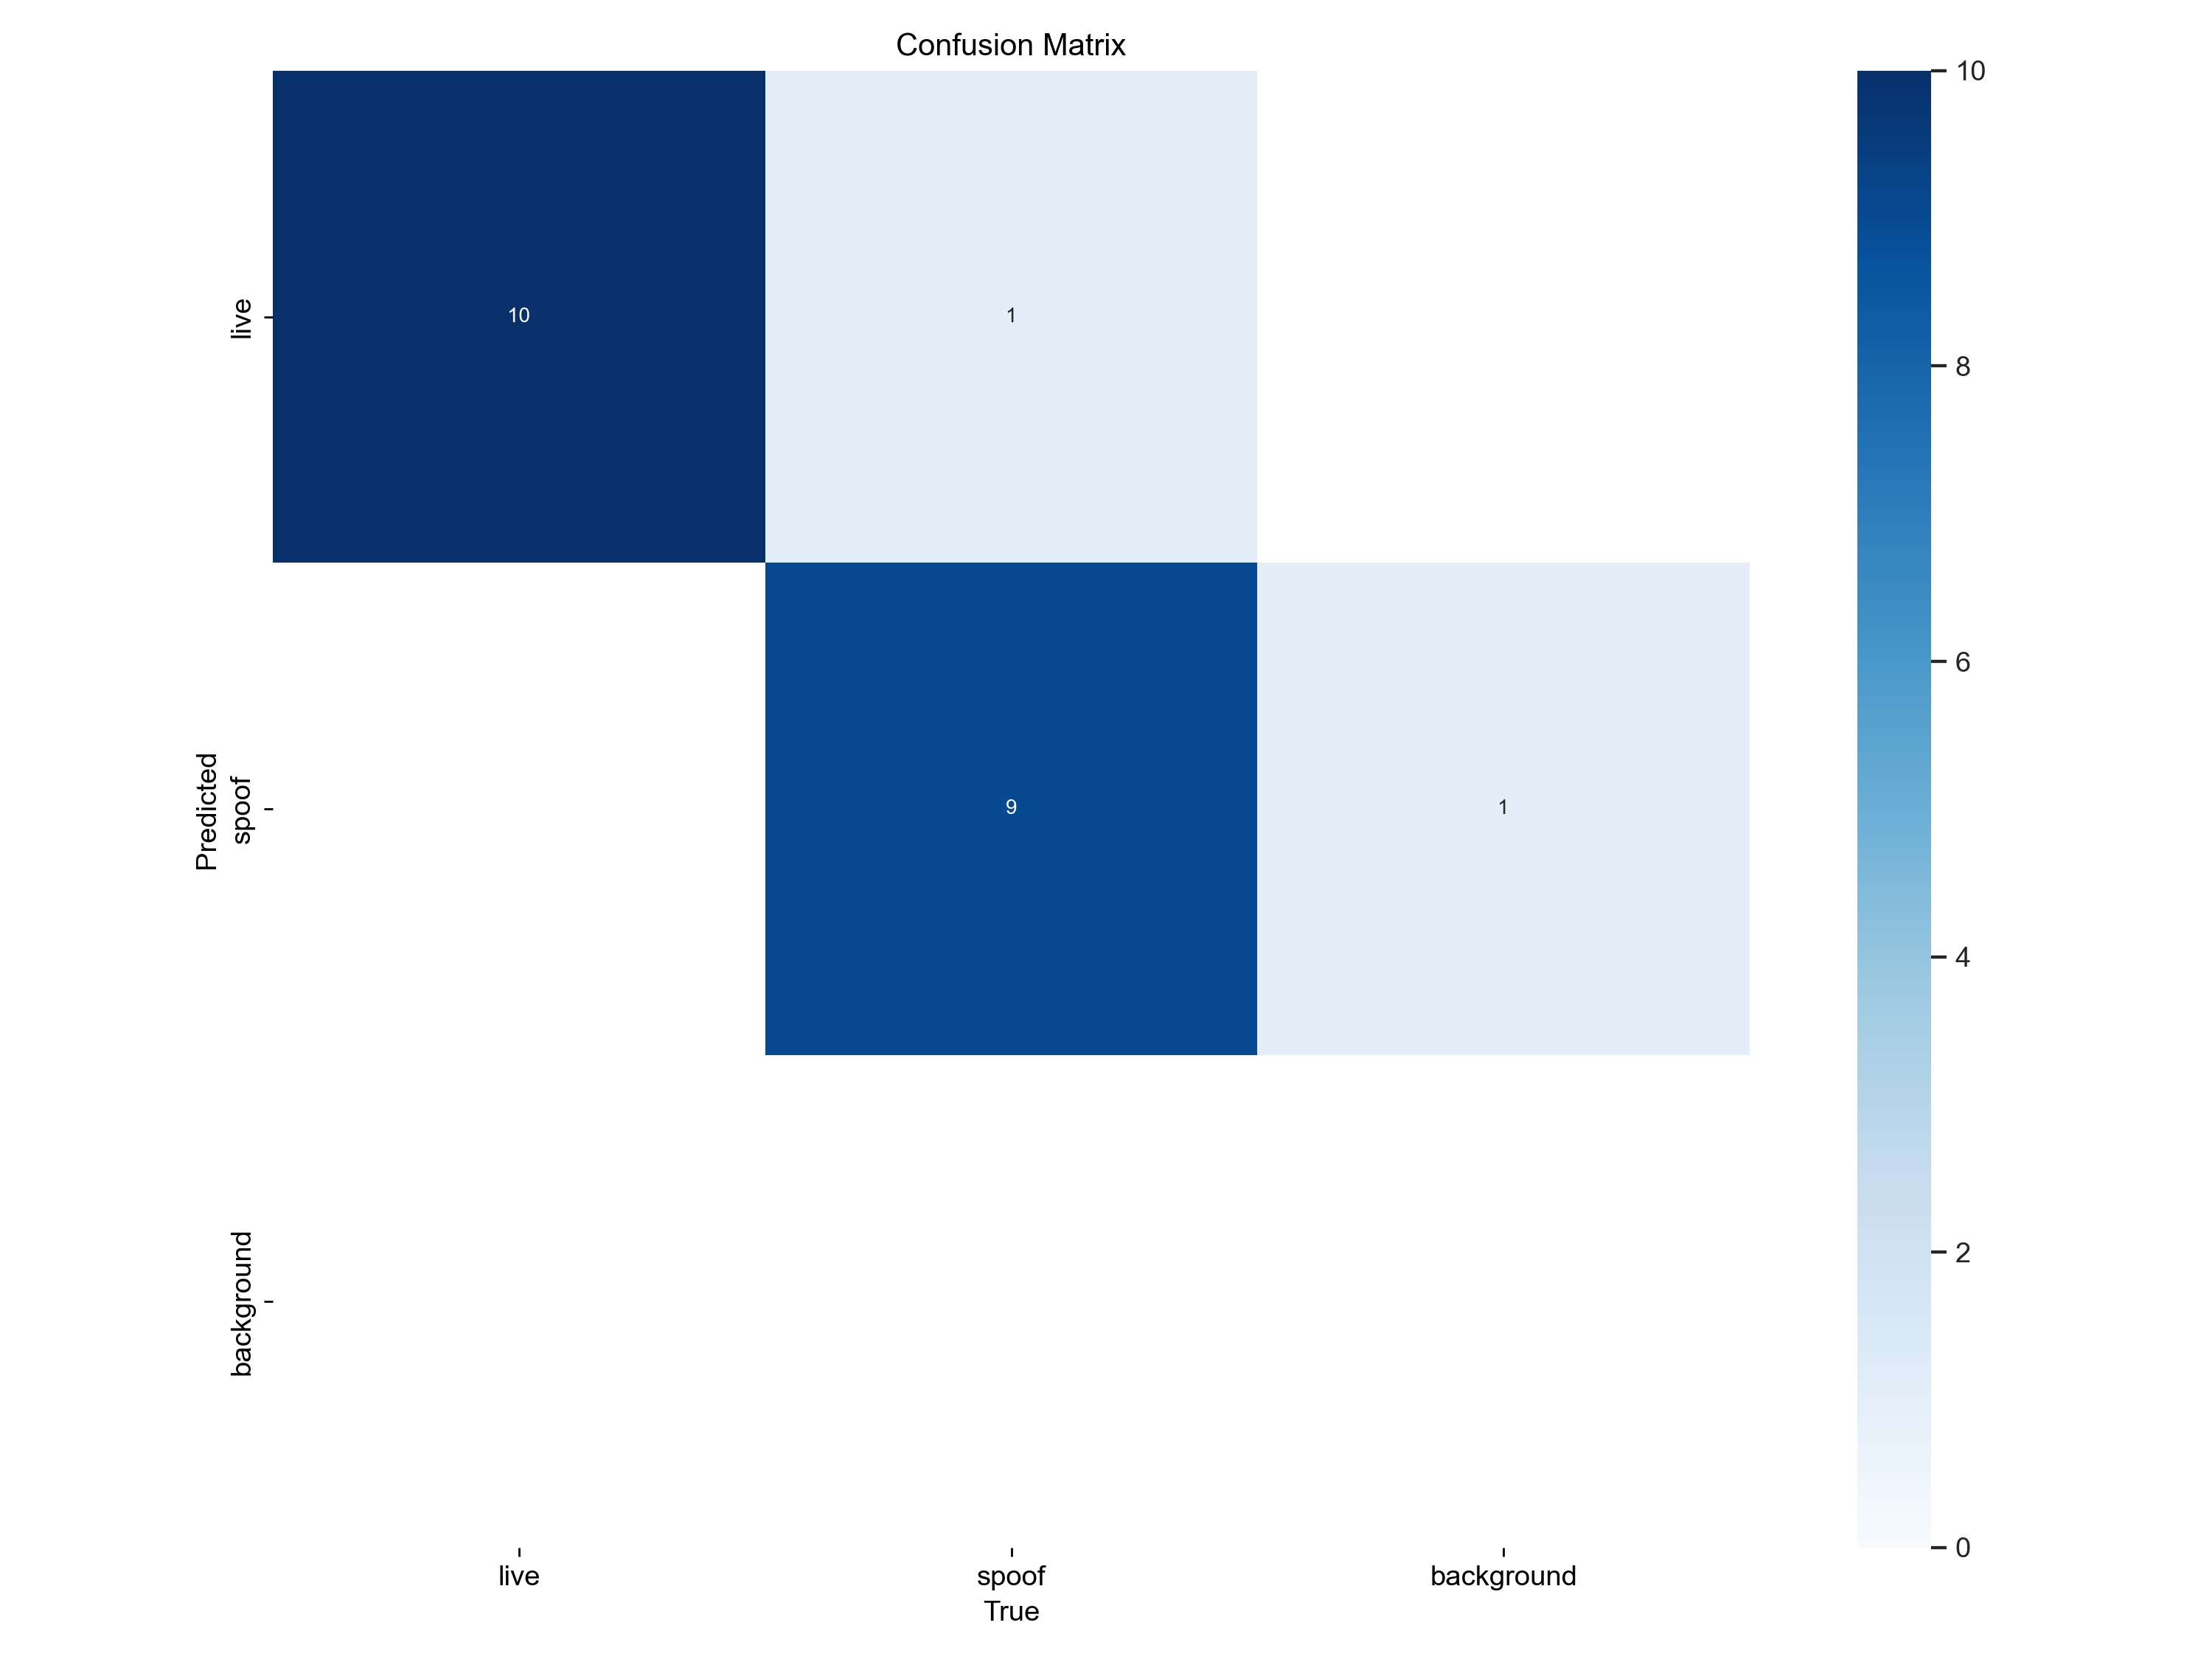

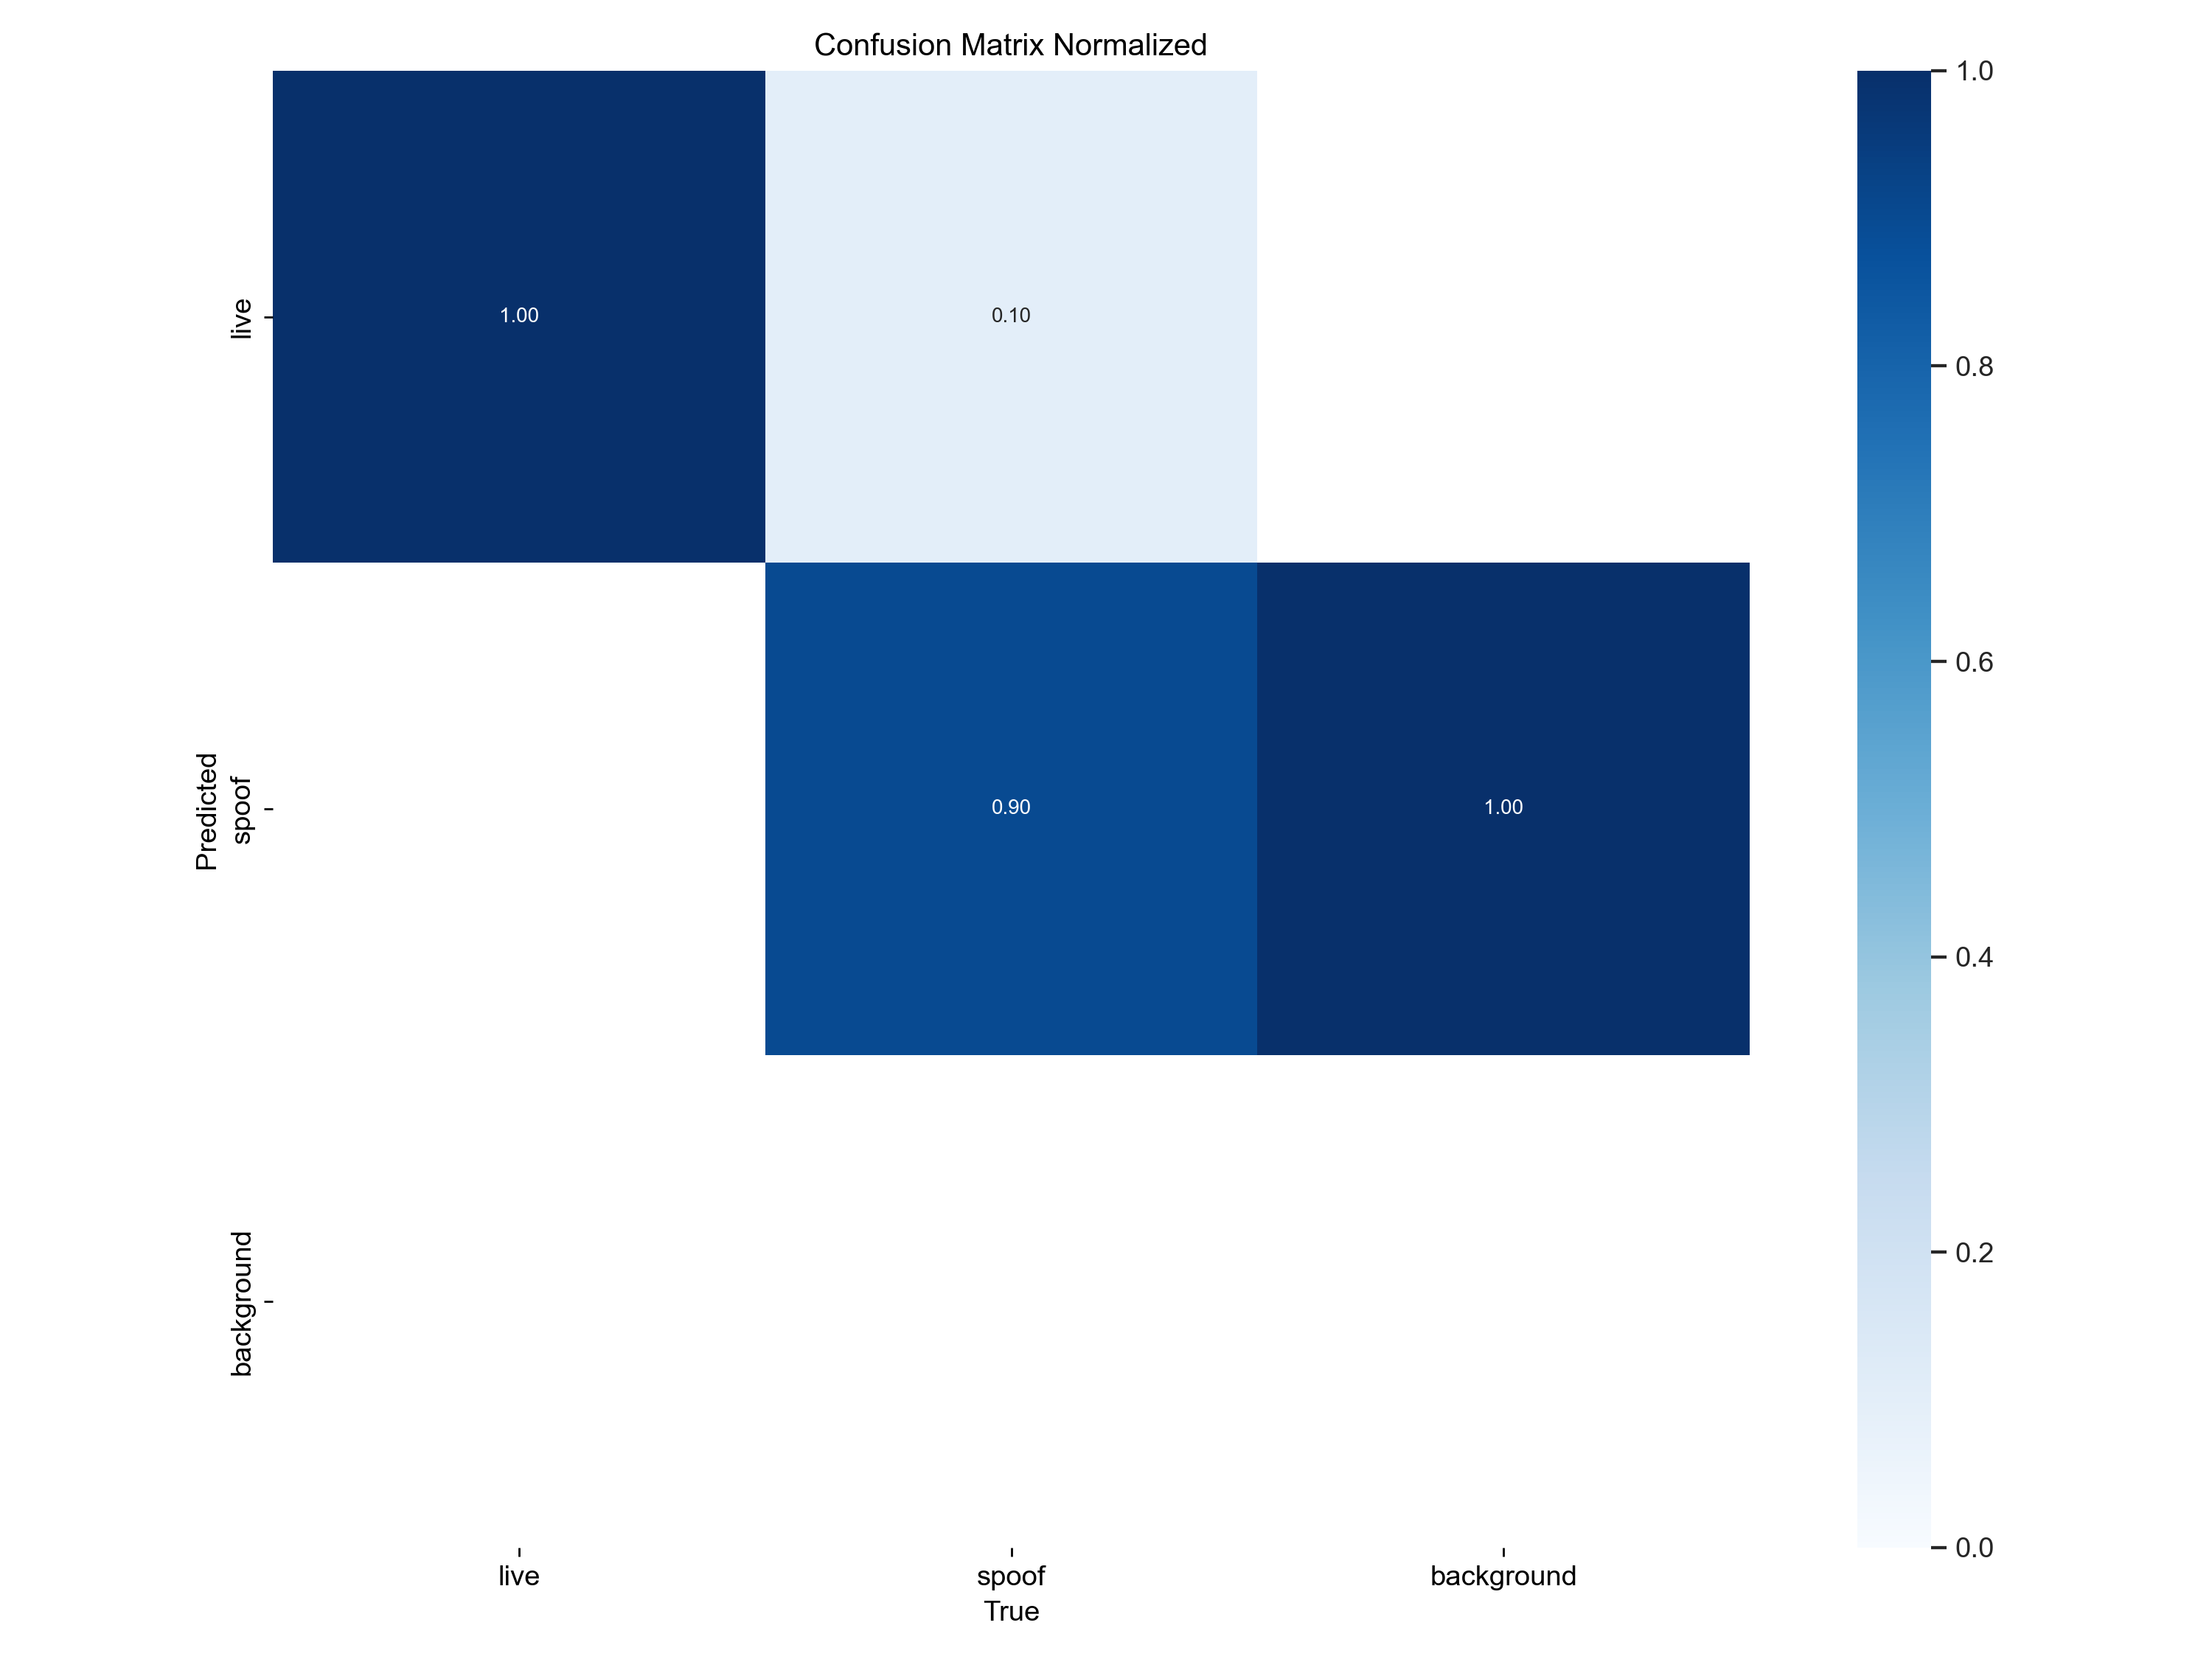

In [7]:
# save_dir = results.save_dir 
save_dir = '../runs/detect/train'

for img_name in ['confusion_matrix.png', 'confusion_matrix_normalized.png']:
  display(Image(filename=f'{save_dir}/{img_name}', width=600))

### 2. Overall Training Results

In [10]:
'''
Your explanation here
'''

'\nYour explanation here\n'

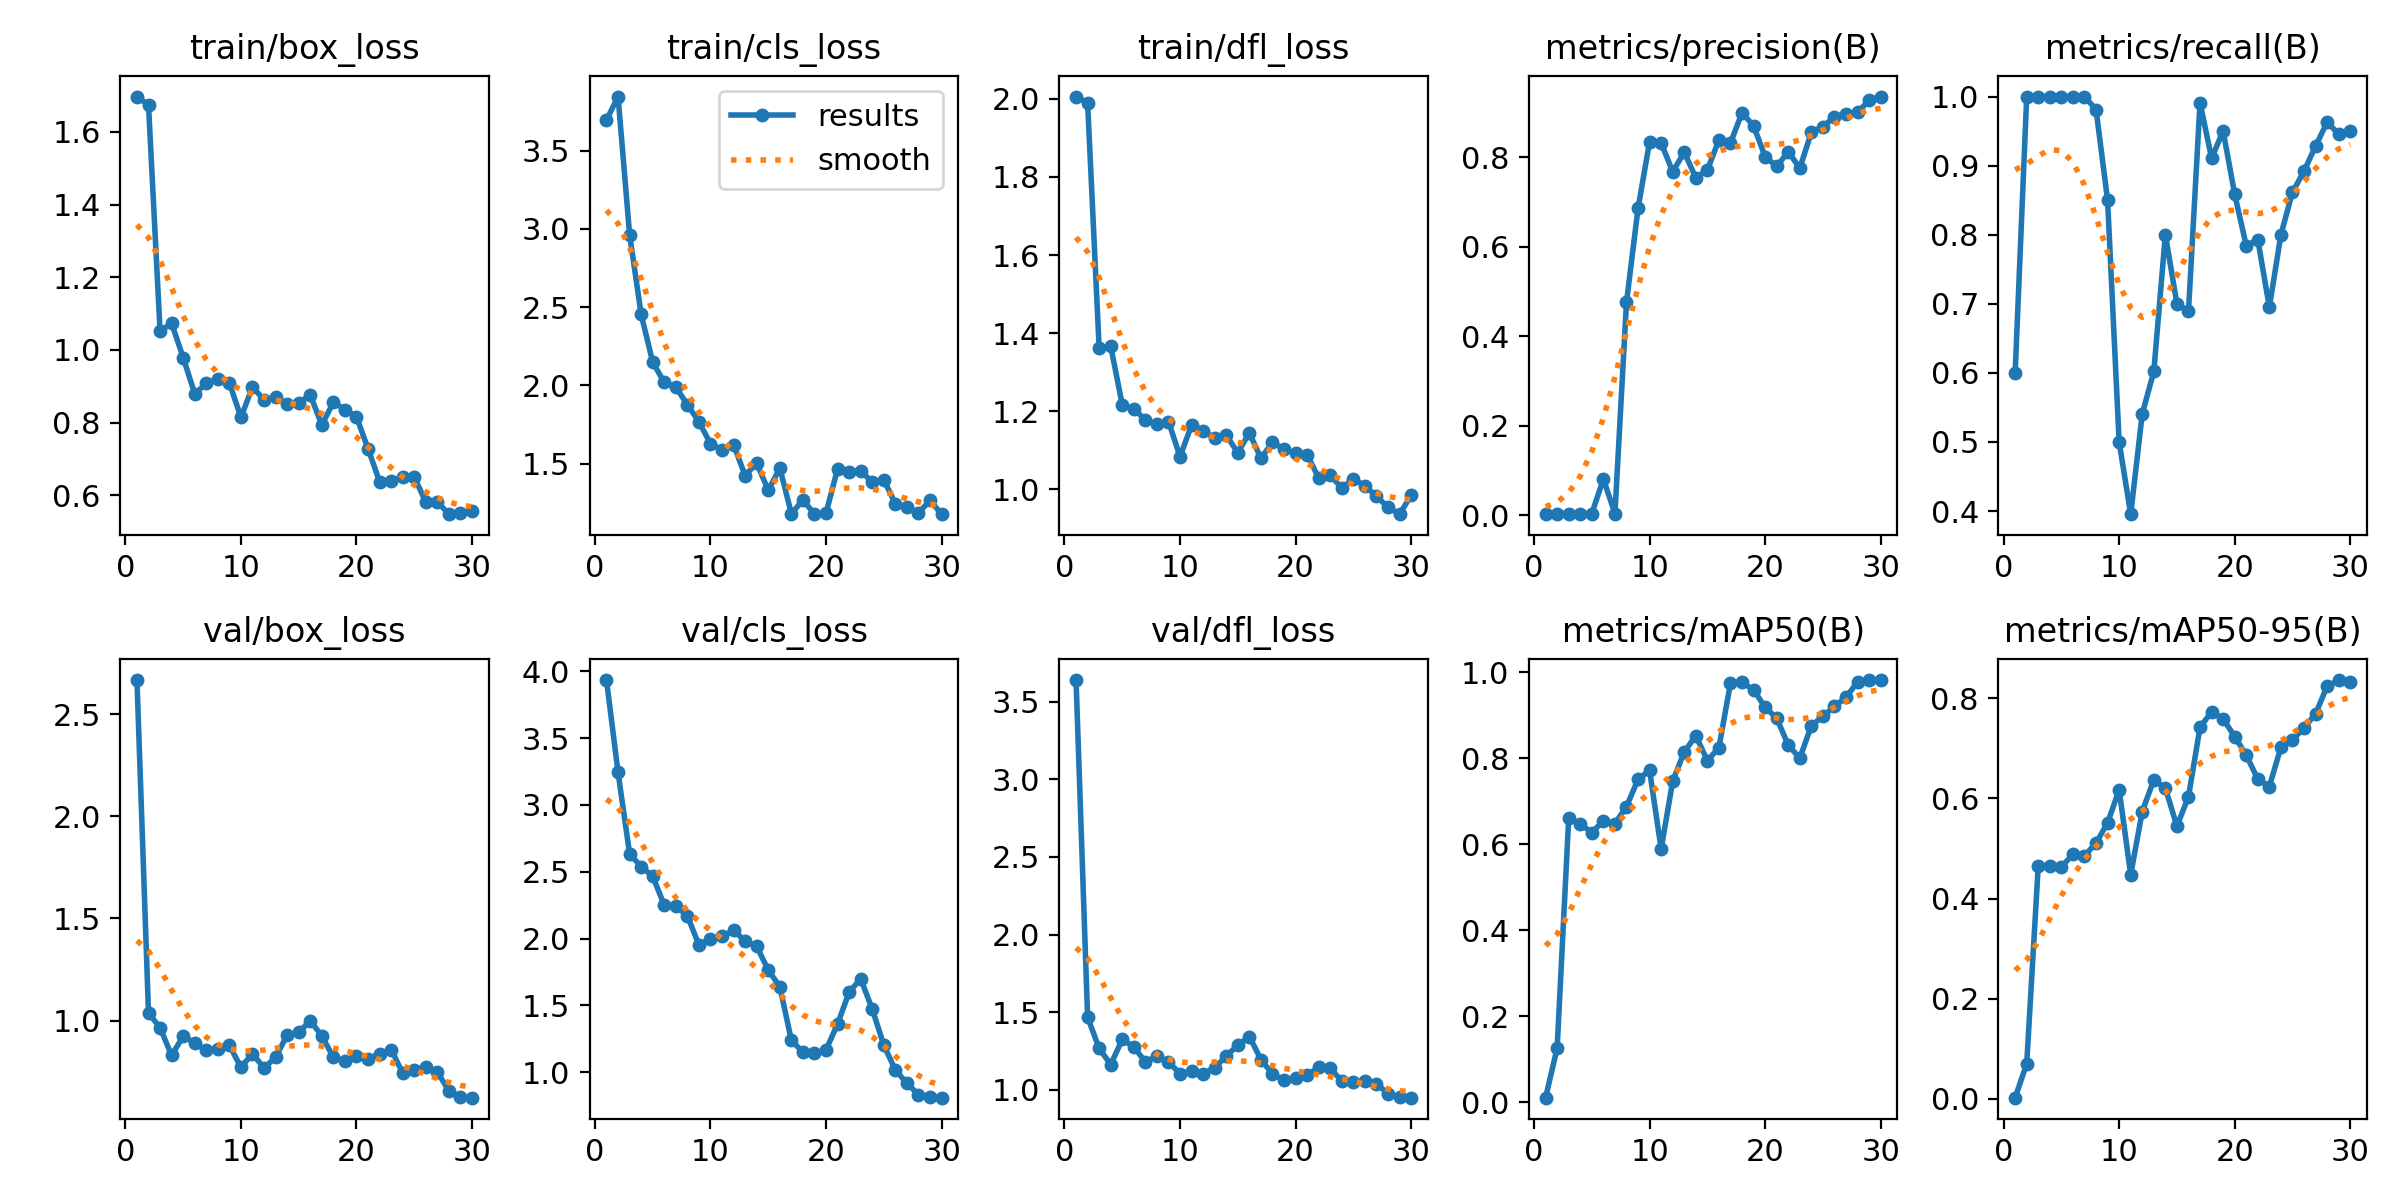

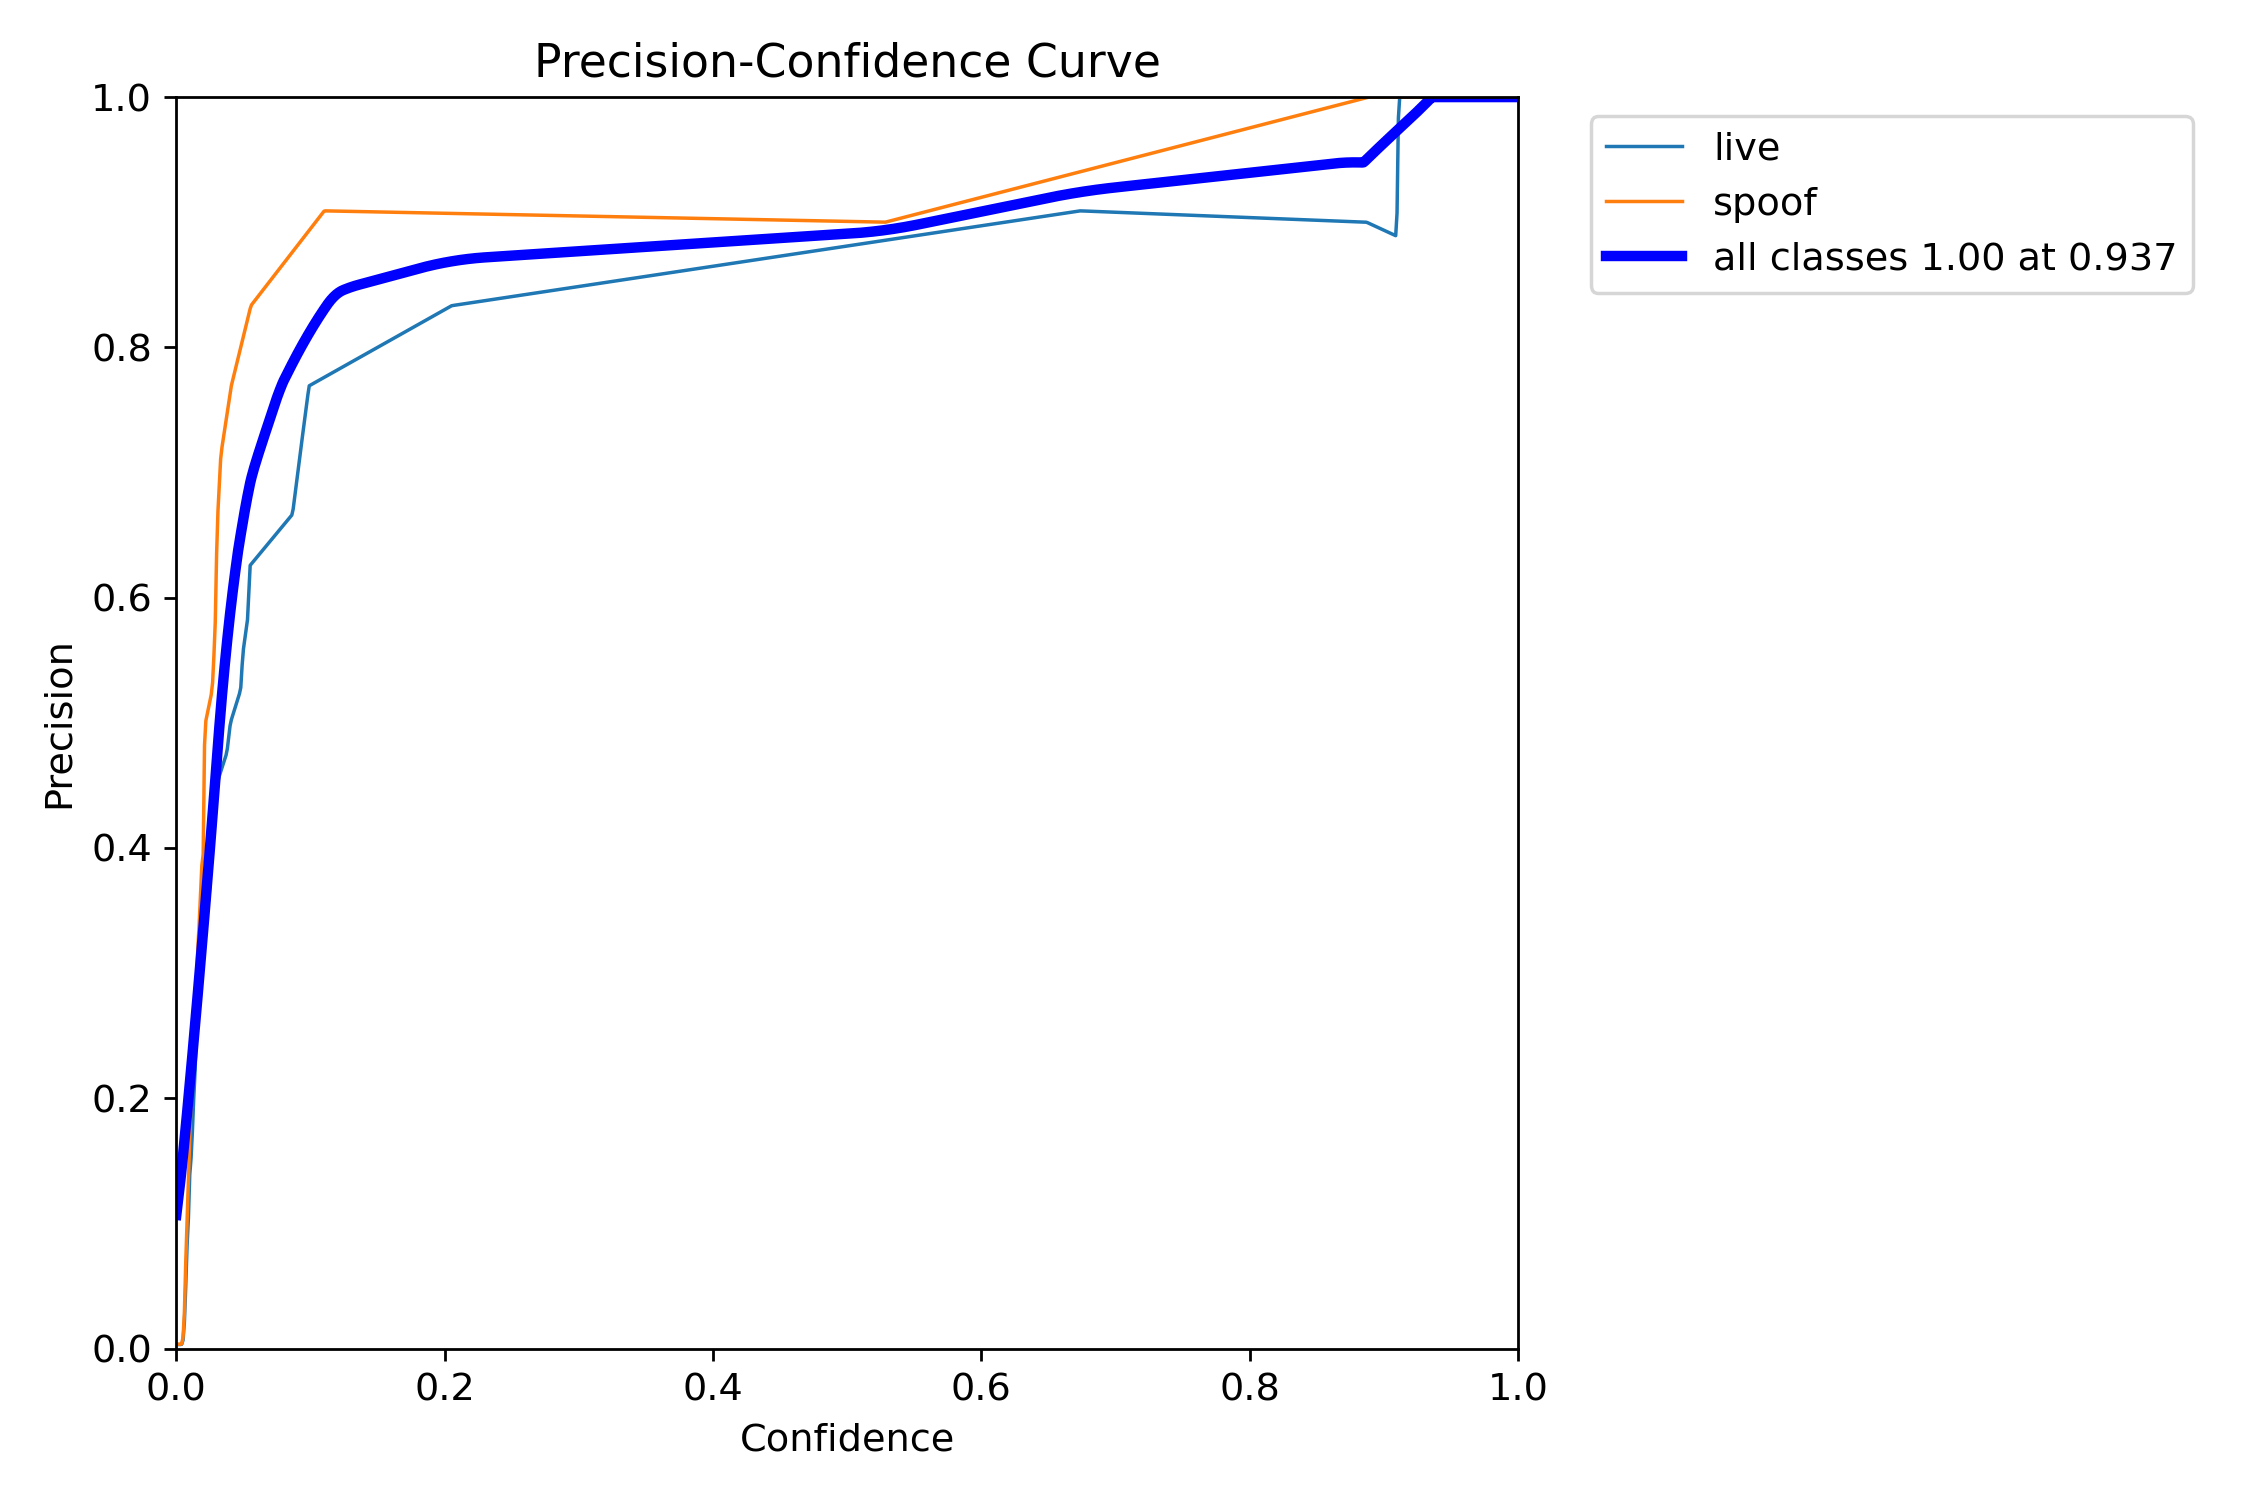

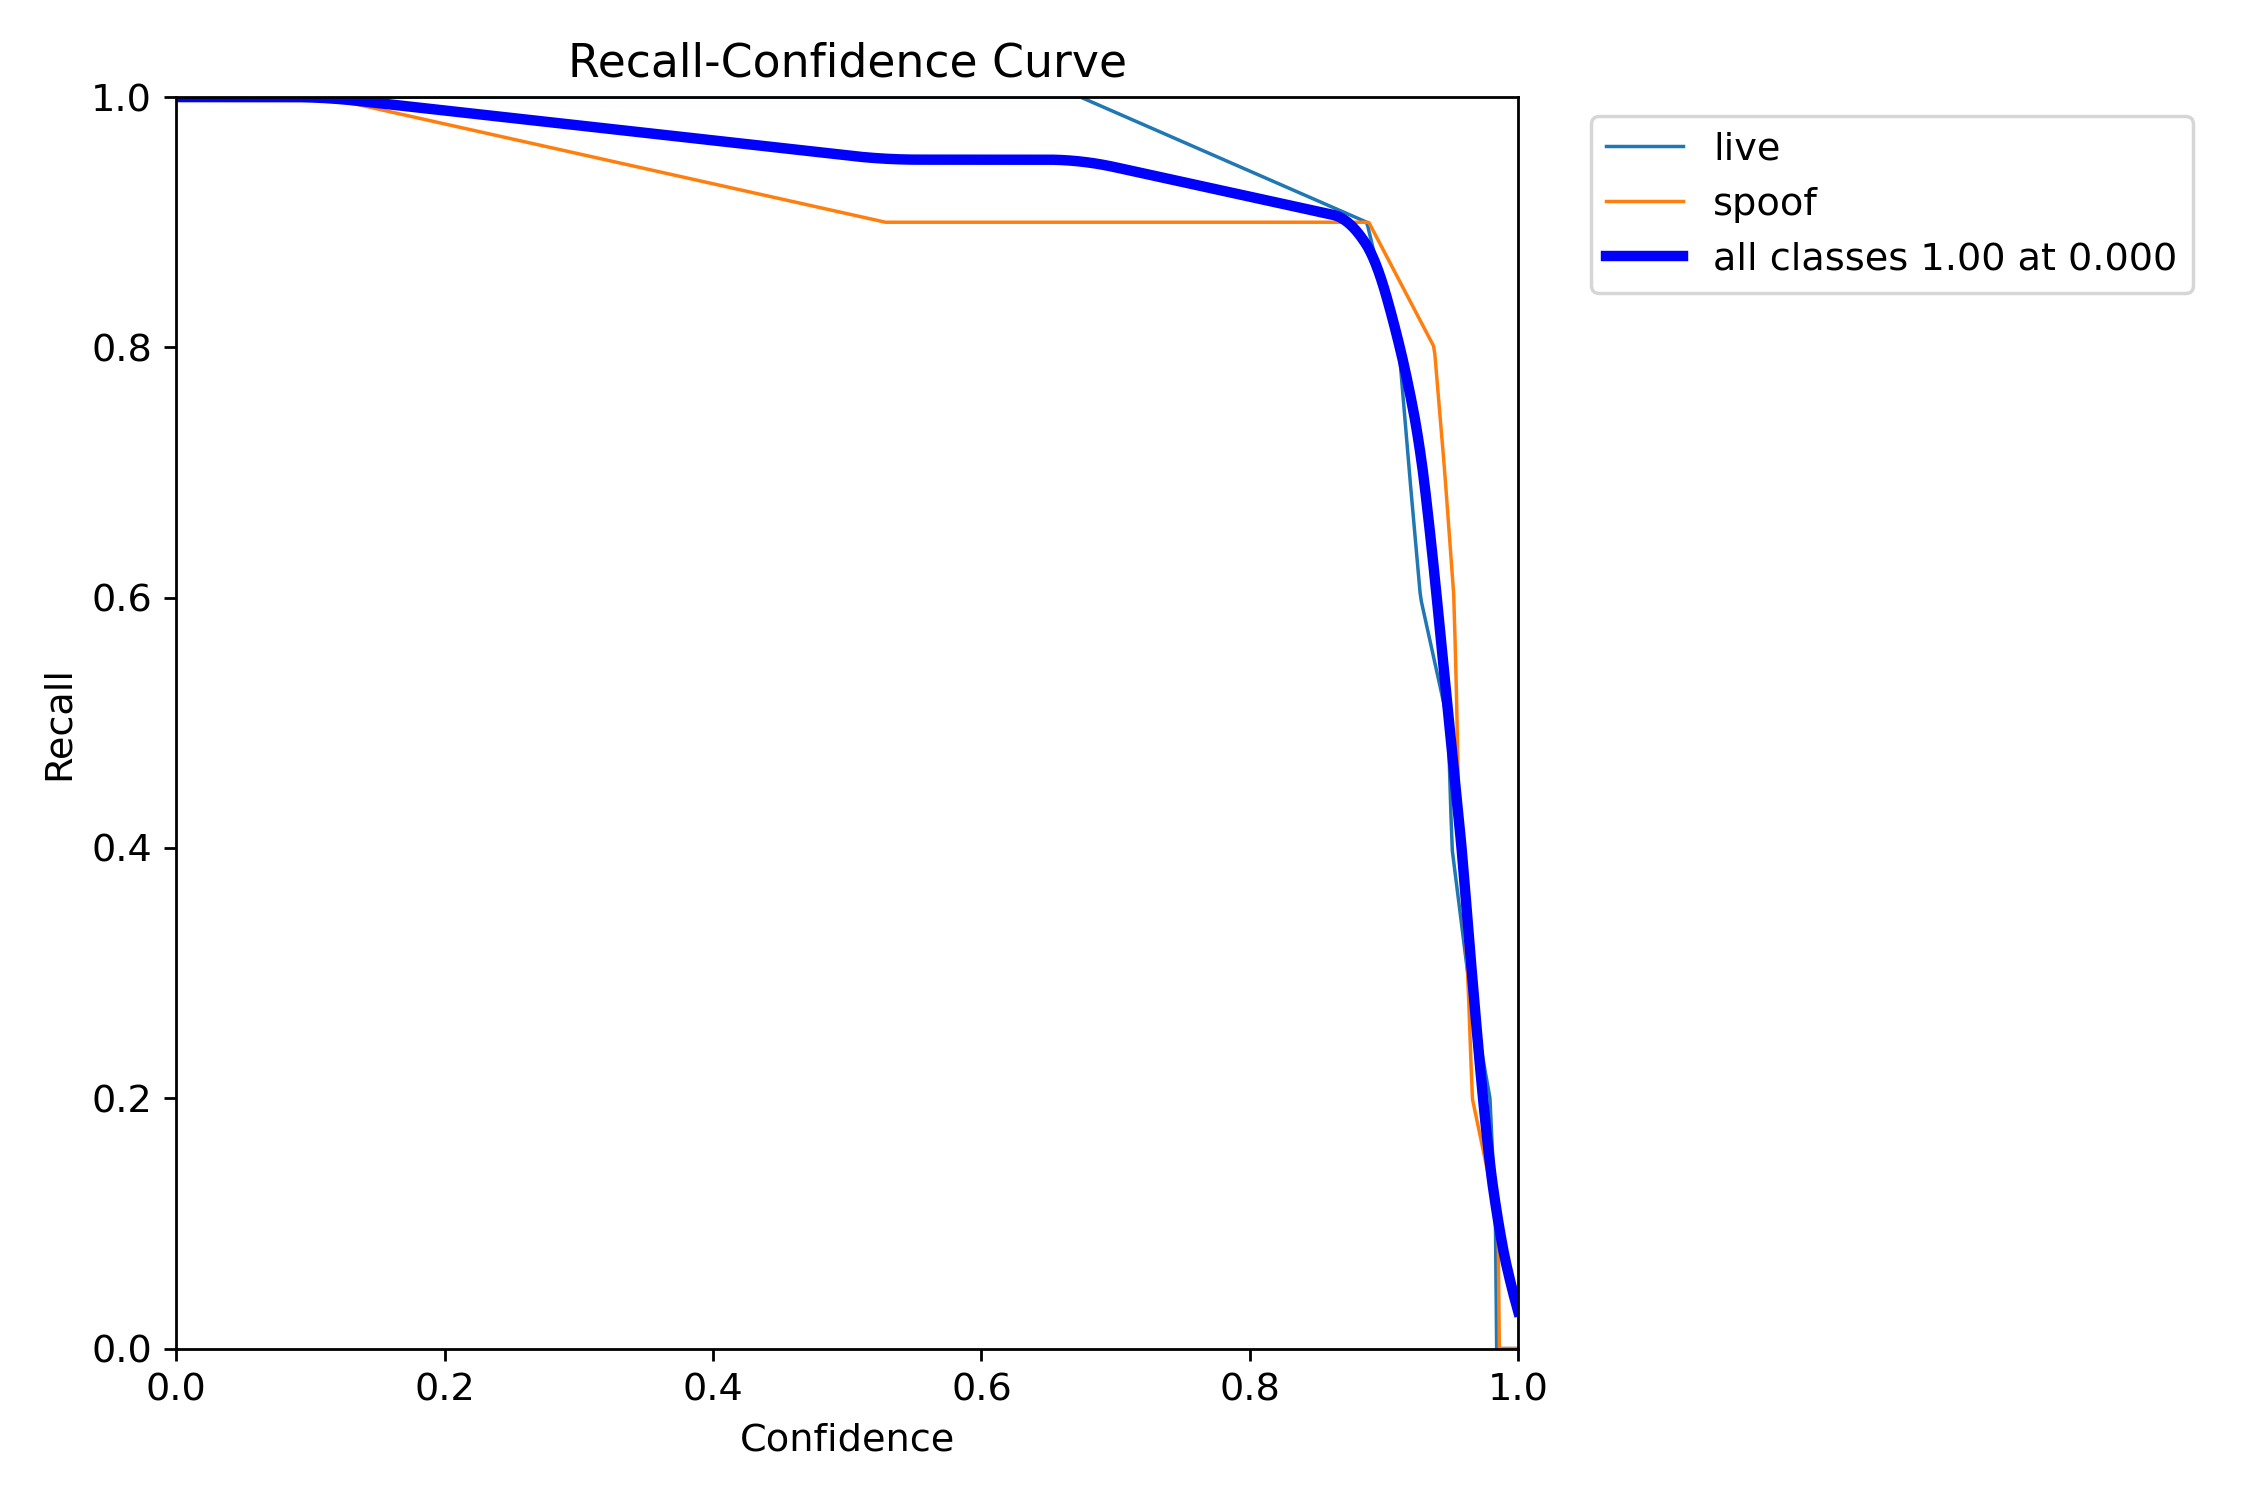

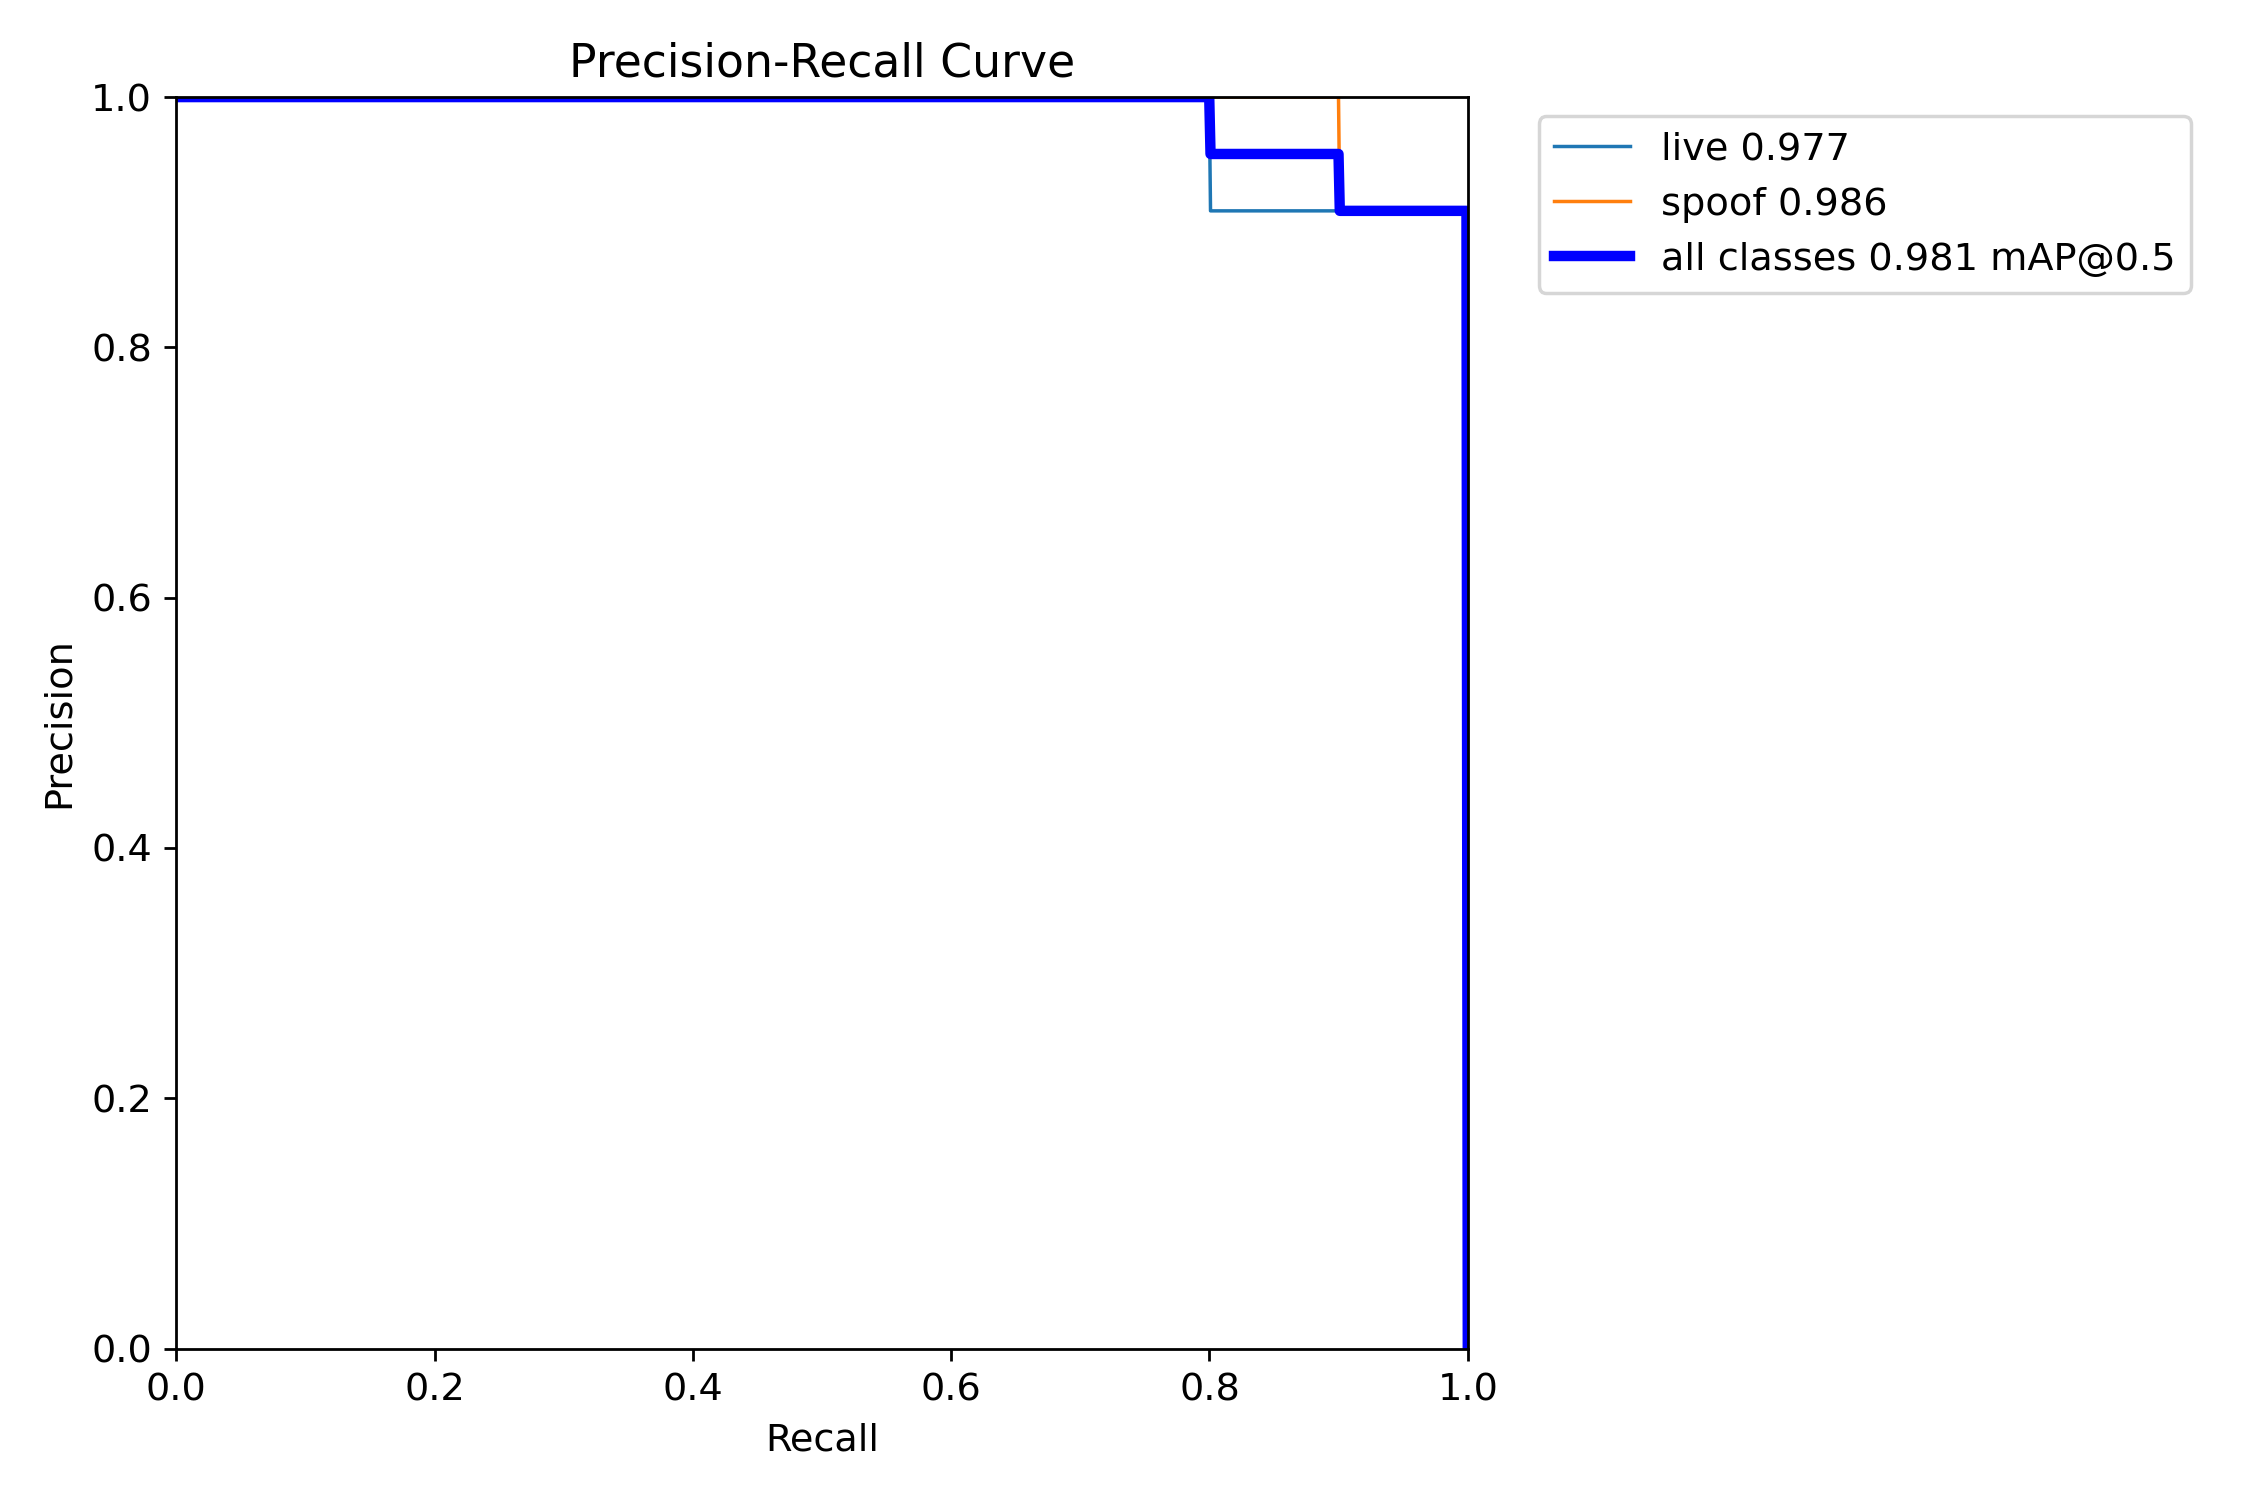

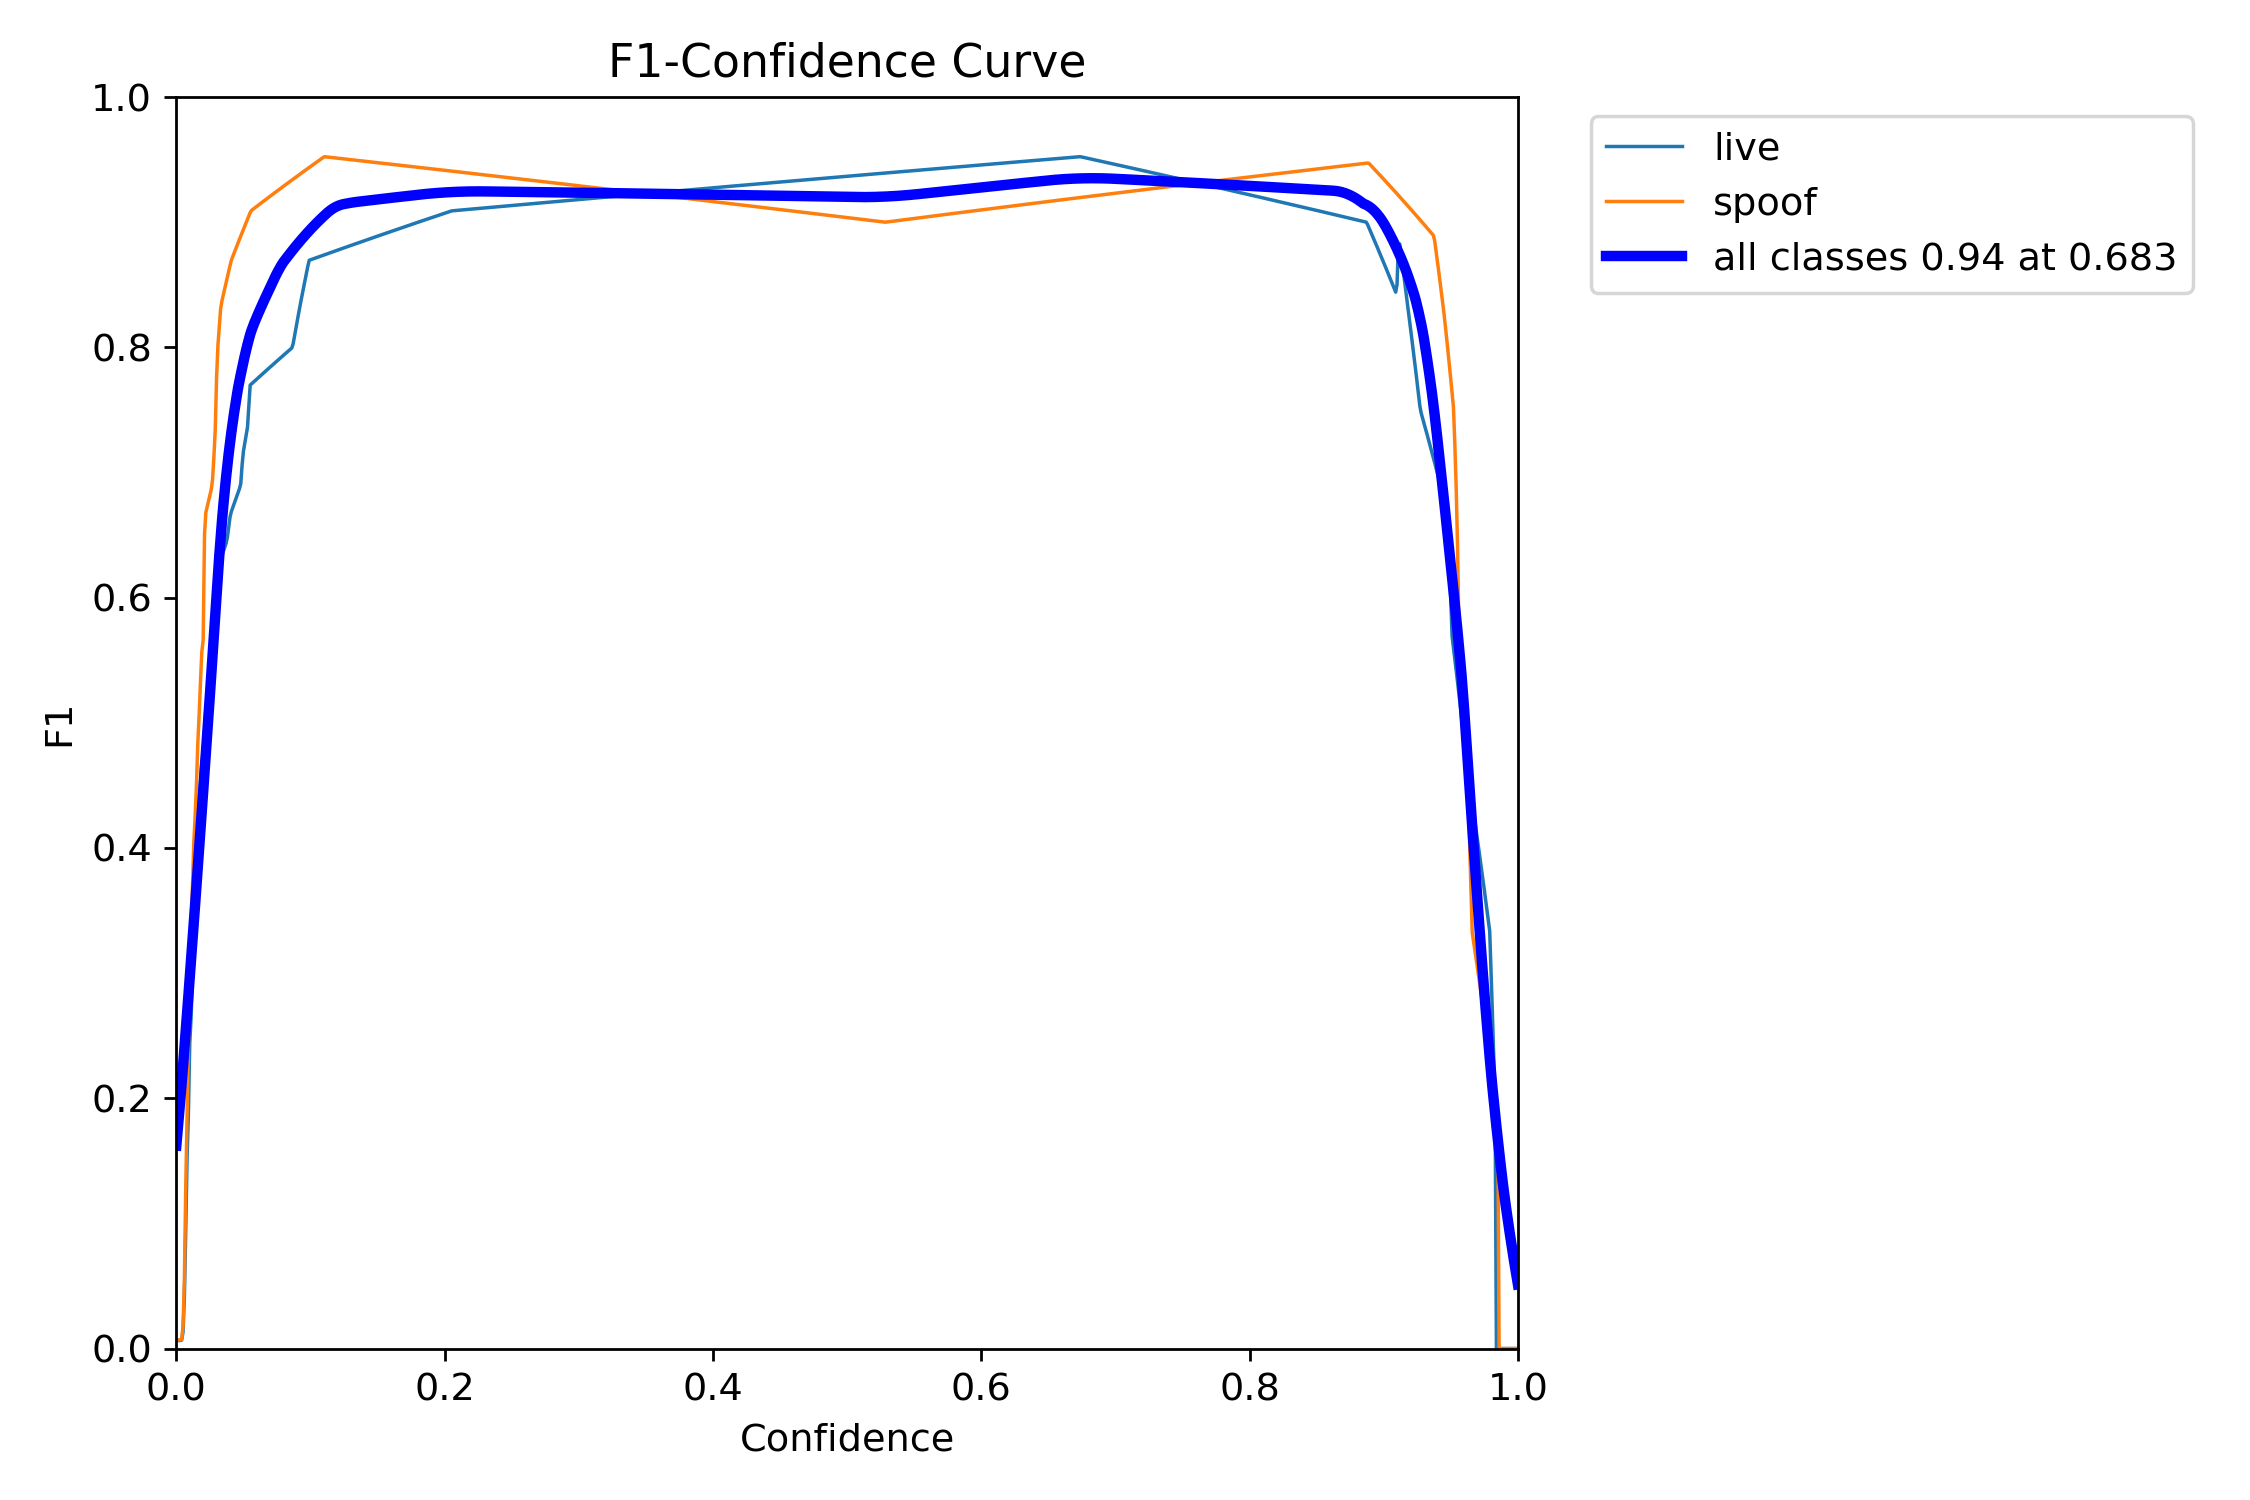

In [43]:
'''
fill your code to visualize your overall training and validation results if any (plots and/or table)
'''
for img_name in ['results.png', 'P_curve.png', 'R_curve.png', 'PR_curve.png', 'F1_curve.png']:
  display(Image(filename=f'{save_dir}/{img_name}', width=600))

### 3. Visualize on Validation Set

In [12]:
'''
Your explanation here
'''

'\nYour explanation here\n'

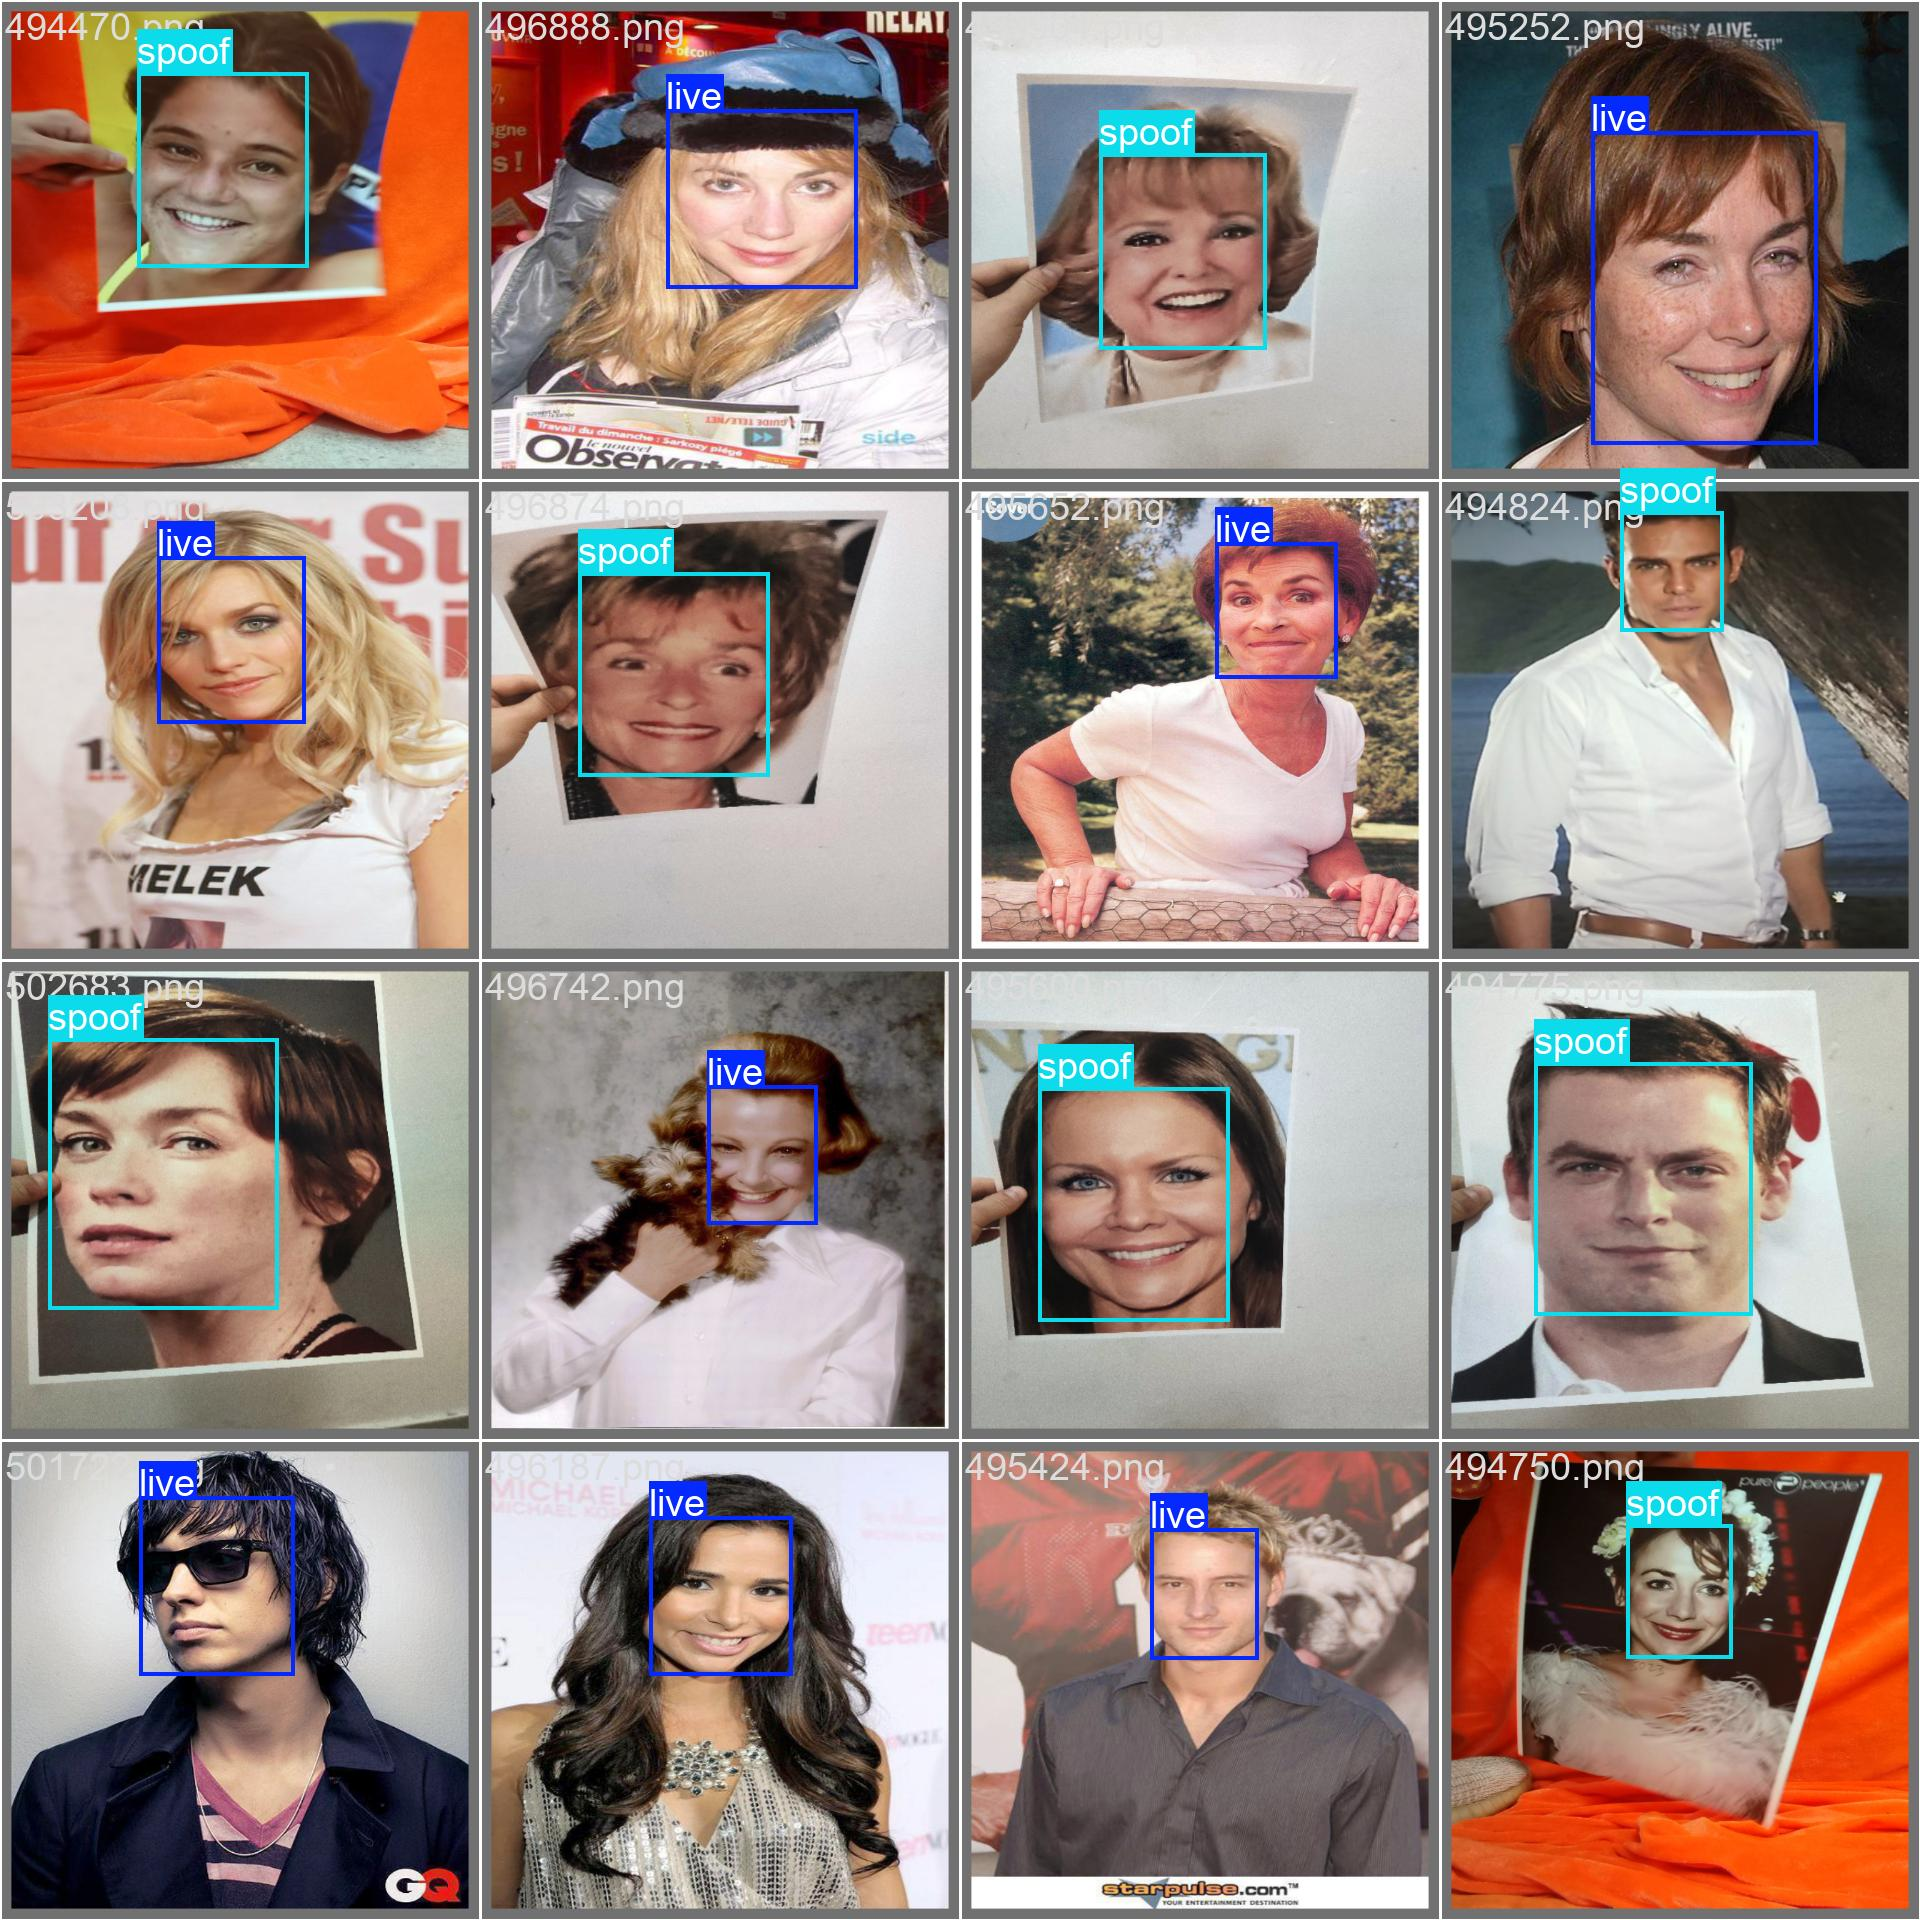

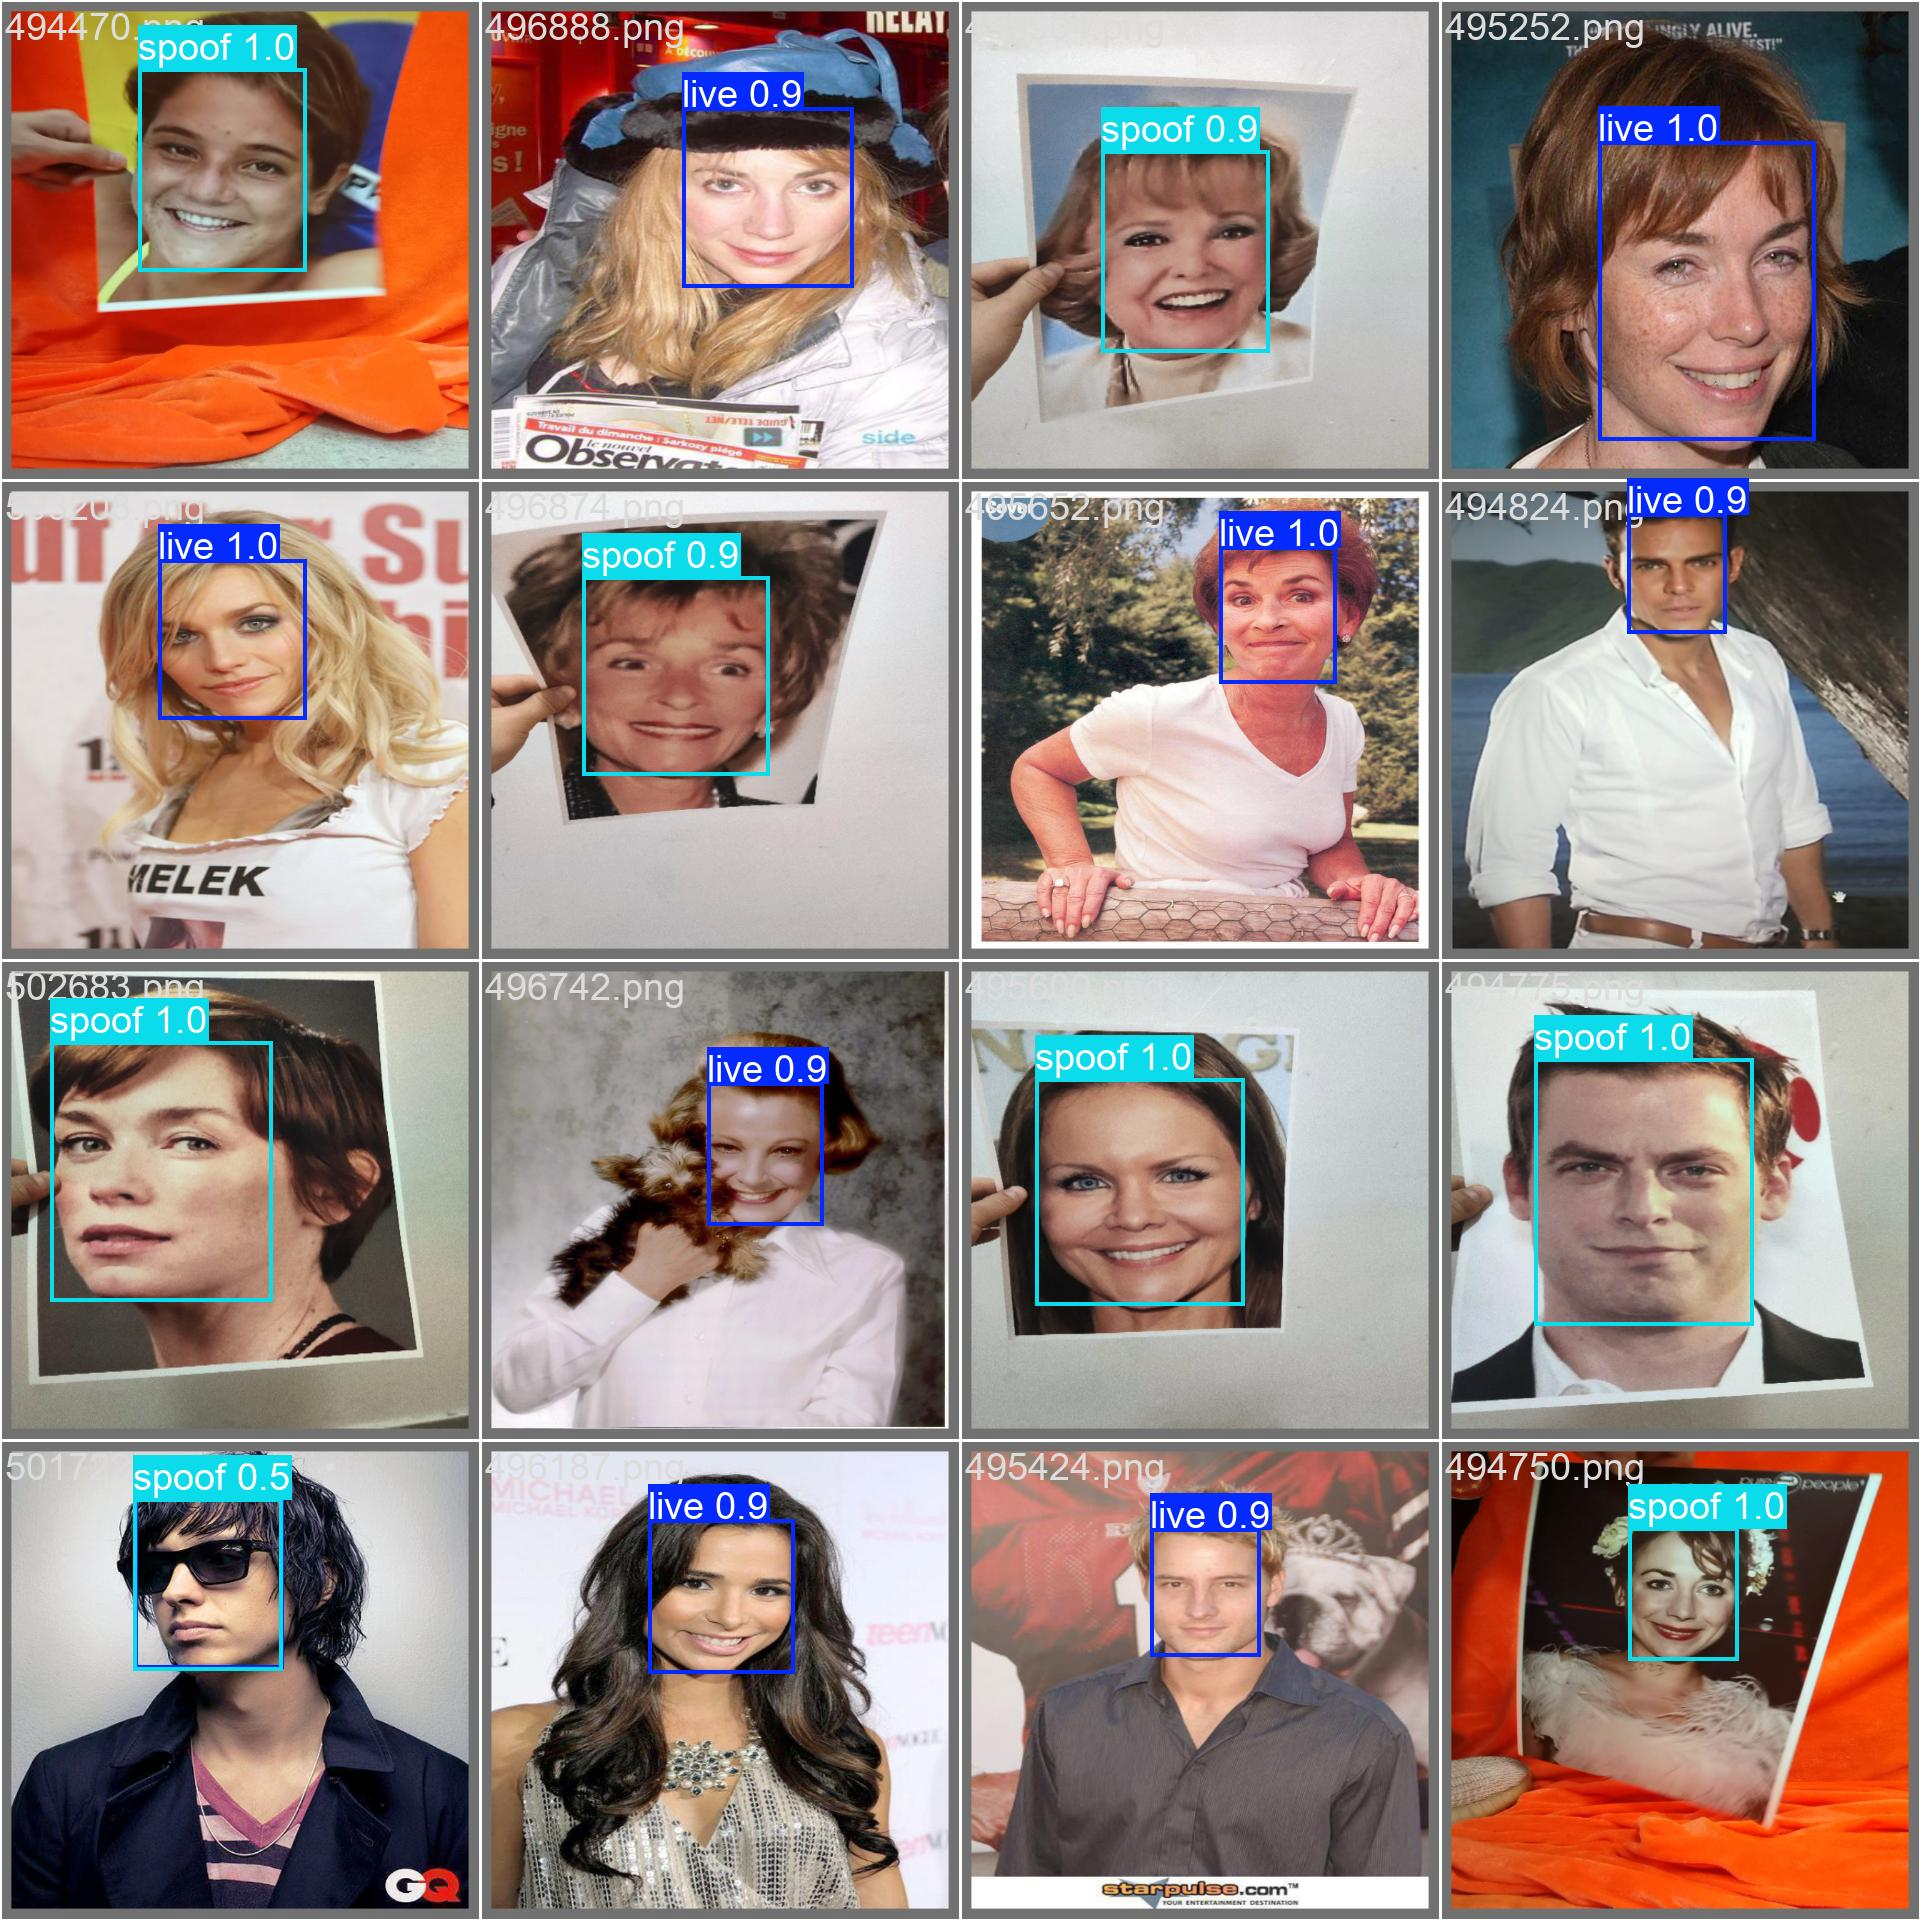

In [44]:
for img_name in ['val_batch0_labels.jpg', 'val_batch0_pred.jpg']:
  display(Image(filename=f'{save_dir}/{img_name}', width=600))

## E) EVALUATION
- test sets can be found at `data/datasets/test`

In [14]:
'''
Your explanation here
'''

'\nYour explanation here\n'


0: 640x640 1 spoof, 21.9ms
1: 640x640 1 spoof, 21.9ms
2: 640x640 1 spoof, 21.9ms
3: 640x640 (no detections), 21.9ms
4: 640x640 1 spoof, 21.9ms
5: 640x640 1 spoof, 21.9ms
6: 640x640 1 live, 21.9ms
7: 640x640 1 spoof, 21.9ms
8: 640x640 1 spoof, 21.9ms
9: 640x640 1 spoof, 21.9ms
10: 640x640 2 spoofs, 21.9ms
11: 640x640 1 spoof, 21.9ms
12: 640x640 1 live, 21.9ms
13: 640x640 1 spoof, 21.9ms
14: 640x640 1 live, 21.9ms
15: 640x640 1 live, 21.9ms
16: 640x640 1 spoof, 21.9ms
17: 640x640 1 live, 21.9ms
18: 640x640 1 spoof, 21.9ms
19: 640x640 1 spoof, 21.9ms
Speed: 3.5ms preprocess, 21.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


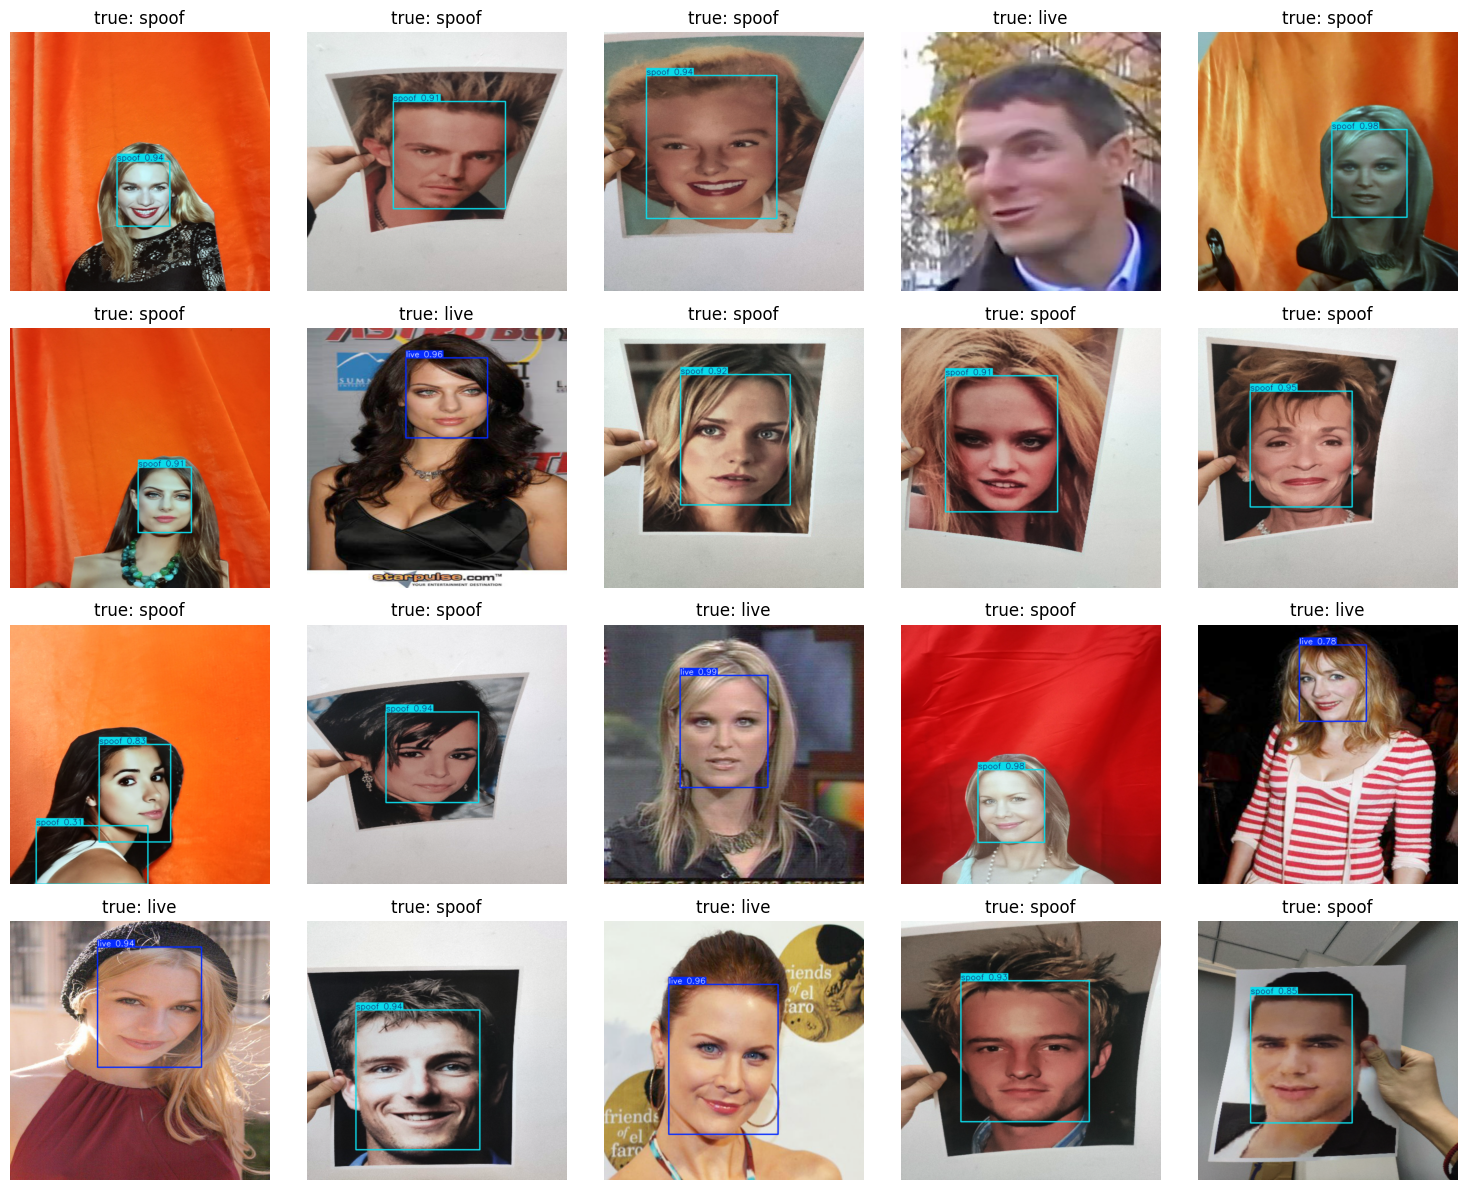

In [43]:
model = YOLO(f'{save_dir}/weights/best.pt')  

# Run batched inference on a list of images
image_folder = f'{dataset_processed_path}/images/test'
label_folder = f'{dataset_processed_path}/labels/test'
image_files = [os.path.join(image_folder, file) for file in sorted(os.listdir(image_folder))]
label_files = [os.path.join(label_folder, file) for file in sorted(os.listdir(label_folder))]
results = model(image_files)  # return a list of Results objects

num_images = len(image_files)
cols = 5
rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

# Process results and plot each image
for i, result in enumerate(results):
    # Load real label
    with open(label_files[i], 'r') as file:
        line = file.readline().strip().split()
        label = 'spoof' if int(line[0]) else 'live'

    # Draw bounding boxes and labels on the image
    axes[i].imshow(cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f'true: {label}')

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## F) CONCLUSION AND IMPROVEMENTS

- Please conclude your work based on all the previous sections. You can use  code, picture or written reasonings.
- example : The model achieves 90% mAP50

In [16]:
'''
Your explanation here
'''

'\nYour explanation here\n'

## G) BONUS POINTS
- Further improve model accuracy
- Further improve model size and inference speed
- Model conversion (to ONNX / TFLite)
- Model serving (FastAPI / Streamlit)
- Dockerization
- Etc.


> Note: You shall provide proof of your improvements.


In [44]:
path = model.export(format="onnx")

Ultralytics YOLOv8.2.74  Python-3.9.19 torch-2.4.0+cu124 CPU (Intel Core(TM) i5-10210U 1.60GHz)

PyTorch: starting from '..\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
